# **Step2_AI 강사 Agent v2.0**

## **0. 미션**

### **미션③ : 모듈 고도화1**
다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.

* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토




### **미션④ : AI 강사 Agent 완성**
* 모듈 고도화2(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
    * 음성 변환 : 강의 목소리, 톤 조절 음성 변환
    * 영상 제작 :
        * 각 페이지 : 음성과 슬라이드 스냅샷 이미지 합성하여 영상 제작하기
        * 전체 강의 영상 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 웹 화면 연결(gradio)
    * 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 전체 Agent 그래프 구축
    * 전체를 Agent 그래프로 엮기


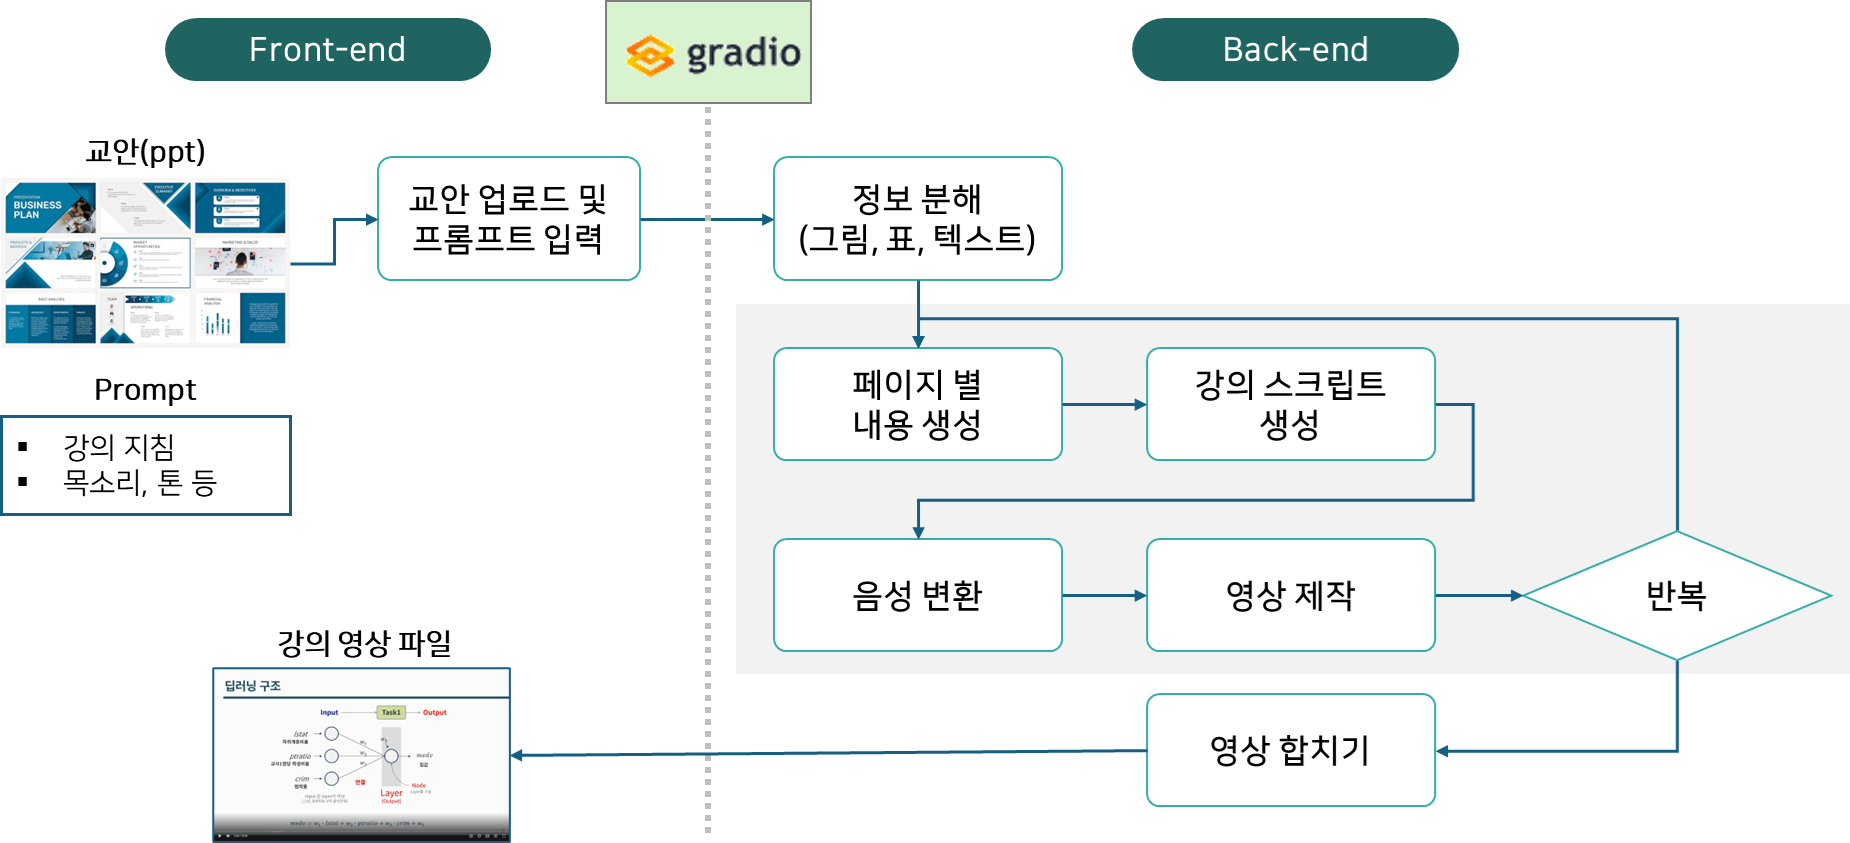

## **1. 환경준비**

### (1) 구글 드라이브

* 구글 드라이브 폴더 생성
    * 새 폴더(project_multi_modal)를 생성하고
    * 제공 받은 파일을 업로드

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 한글 폰트 준비
* 한글 폰트 설치 및 설정 코드
* 영상 제작 등 한글 사용시 필요

In [2]:
!apt-get -y install ffmpeg libreoffice poppler-utils poppler-data locales \
                   fonts-noto-cjk fonts-noto-cjk-extra fonts-nanum fonts-unfonts-core
!sed -i 's/^# *ko_KR.UTF-8 UTF-8/ko_KR.UTF-8 UTF-8/' /etc/locale.gen
!locale-gen ko_KR.UTF-8
!update-locale LANG=ko_KR.UTF-8
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.11).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  apparmor at-spi2-core ca-certificates-java default-jre default-jre-headless
  dictionaries-common firebird3.0-common firebird3.0-common-doc
  firebird3.0-server-core firebird3.0-utils fonts-crosextra-caladea
  fonts-crosextra-carlito fonts-dejavu fonts-dejavu-core fonts-dejavu-extra
  fonts-liberation2 fonts-linuxlibertine fonts-noto-core fonts-noto-extra
  fonts-noto-mono fonts-noto-ui-core fonts-opensymbol fonts-sil-gentium
  fonts-sil-gentium-basic gsettings-desktop-schemas gstreamer1.0-gl
  gstreamer1.0-gtk3 gstreamer1.0-plugins-base hunspell-en-us java-common
  libabsl20210324 libabw-0.1-1 libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libboost-filesy

In [3]:
%%bash
mkdir -p ~/.config/fontconfig
cat > ~/.config/fontconfig/fonts.conf <<'EOF'
<?xml version="1.0"?>
<!DOCTYPE fontconfig SYSTEM "fonts.dtd">
<fontconfig>

  <!-- ▷ 한국어 텍스트엔 Noto Sans CJK KR을 우선 사용 -->
  <match target="pattern">
    <test name="lang" compare="eq"><string>ko</string></test>
    <edit name="family" mode="prepend" binding="strong">
      <string>Noto Sans CJK KR</string>
    </edit>
  </match>

  <!-- ▷ 일반 가족명에도 기본 대체 추가 -->
  <alias><family>sans-serif</family><prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>serif</family><prefer><family>Noto Serif CJK KR</family></prefer></alias>
  <alias><family>monospace</family><prefer><family>Noto Sans Mono CJK KR</family></prefer></alias>

  <!-- ▷ Windows/macOS/웹에서 흔한 한글 폰트들을 Noto로 매핑 -->
  <alias><family>Malgun Gothic</family>        <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>맑은 고딕</family>             <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Apple SD Gothic Neo</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>AppleGothic</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard</family>           <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard Variable</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>NanumSquare</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Spoqa Han Sans</family>       <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>KoPub</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Gulim</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Dotum</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Batang</family>               <prefer><family>Noto Serif CJK KR</family></prefer></alias>
</fontconfig>
EOF
fc-cache -fv


/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/linux-libertine: caching, new cache contents: 13 fonts, 0 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 11 dirs
/usr/share/fonts/truetype/crosextra: caching, new cache contents: 8 fonts, 0 dirs
/usr/sh

### (3) 라이브러리

* 필요한 라이브러리 설치

In [4]:
!apt-get -y install ffmpeg libreoffice poppler-utils
!pip install python-pptx pillow langgraph google-search-results gradio -q
!pip install reportlab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver do

* 라이브러리 로딩

In [5]:
import os, re, textwrap, subprocess, json, base64, mimetypes, shlex
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, TypedDict, Any
from PIL import Image, ImageDraw
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from openai import OpenAI
from google.colab import files
from IPython.display import Audio, display, Video

from serpapi import GoogleSearch

### (4) OpenAI API Key 확인
* 구글드라이브에 생성한 폴더 'project_multi_modal'에서
* api_key.txt 파일 안에 각자 발급 받은 키를 저장합니다.
    * **openai api key**
    * **SERPAPI_API_KEY**

In [6]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project_multi_modal/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [7]:
print(os.environ['OPENAI_API_KEY'][:30])
print(os.environ['SERPAPI_API_KEY'][:30])

sk-proj-ztdmIJCqhsBaeBPFPDA8CN
f9129dc966aedd0833298ad5a3ce6a


### (5) 유용한 함수들 제공
* 다음은 프로젝트를 수행하는데 유용한 함수들입니다.
* 이 함수들의 내용을 확인하고 필요시 활용하여 개인 과제를 수행합니다.(꼭 활용해야 하는 것은 아닙니다.)

* 공백 제거 함수

In [8]:
def clean_text(s):
    return re.sub(r"\s+", " ", s).strip()

* 긴 문자열을 문장 단위로 나누는 문장 분리기

In [9]:
def split_sents(t: str) -> List[str]:
    parts = re.split(r'([\.?!])', t)
    merged = []
    for i in range(0, len(parts)-1, 2):
        sent = (parts[i] + parts[i+1]).strip()
        if sent: merged.append(sent)
    if len(parts) % 2 == 1 and parts[-1].strip():
        merged.append(parts[-1].strip())
    return [s for s in merged if s]

* 오디오 길이 계산

In [10]:
def ffprobe_duration(path: str) -> float:
    out = subprocess.check_output([
        "ffprobe","-v","error","-show_entries","format=duration",
        "-of","default=noprint_wrappers=1:nokey=1", path]).decode().strip()
    return float(out)

* 이미지를 base64로 변환

In [11]:
def img_to_data_url(path: str) -> str:
    mime = mimetypes.guess_type(path)[0] or "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

* 배경 이미지와 오디오 합쳐서 MP4 영상 만들기

In [12]:
def render_mp4(image_path: str, audio_path: str, out_mp4: str,
               width=1920, height=1080, ):

    dur = ffprobe_duration(audio_path)

    vf = (f"scale={width}:{height}:force_original_aspect_ratio=decrease,"
          f"pad={width}:{height}:(ow-iw)/2:(oh-ih)/2:color=black"  )

    # FFmpeg 명령
    cmd = ["ffmpeg", "-y",
            "-loop", "1", "-i", image_path,   # 정지 이미지 입력
            "-i", audio_path,                 # 오디오 입력
            "-t", str(dur),                   # 길이 = 오디오 길이
            "-vf", vf,                        # 비디오 필터
            "-c:v", "libx264", "-preset", "veryfast", "-crf", "20",
            "-c:a", "aac", "-b:a", "192k",
            "-pix_fmt", "yuv420p",
            "-movflags", "+faststart",        # 웹/브라우저 재생 친화
            out_mp4]
    subprocess.check_call(cmd)  # 외부 프로그램(FFmpeg)을 파이썬 프로세스에서 실행하고, 성공했는지 확인

* ppt 슬라이드를 배경 이미지로 저장
    * 강의 영상에서 사용할 배경 이미지 생성하기
    * ppt를 pdf로 변환한 뒤 다시 이미지로 변환

In [13]:
# 수정 완료
def export_slide_as_png(state: dict, dpi: int = 220) -> dict:
    work_dir = Path(state["work_dir"]).expanduser().resolve()
    work_dir.mkdir(parents=True, exist_ok=True)

    pptx = Path(state["pptx_path"]).expanduser().resolve()
    if not pptx.exists():
        raise FileNotFoundError(f"PPTX 없음: {pptx}")

    idx = int(state.get("slide_index", 0))  # 0-based
    page_no = idx + 1
    out_prefix = work_dir / "slide_img"

    env = os.environ.copy()
    env.update({
        "LANG": "ko_KR.UTF-8",
        "LC_ALL": "ko_KR.UTF-8",
    })

    # --- 1️⃣ PPT → PDF (한 번만 변환) ---
    pdf_path = work_dir / f"{pptx.stem}.pdf"
    if not pdf_path.exists():
        lo_cmd = [
            "soffice","--headless",
            "-env:UserInstallation=file:///tmp/lo_profile",
            "--convert-to","pdf:impress_pdf_Export",
            "--outdir", str(work_dir),
            str(pptx),
        ]
        res_pdf = subprocess.run(lo_cmd, capture_output=True, text=True, env=env)
        if res_pdf.returncode != 0:
            print("LibreOffice 변환 실패")
            print("stdout:", res_pdf.stdout)
            print("stderr:", res_pdf.stderr)
            raise RuntimeError("PPTX → PDF 변환 실패")

    # --- 2️⃣ PDF → PNG (슬라이드별 추출) ---
    png_path = work_dir / f"{out_prefix.stem}-{page_no}.png"
    ppm_cmd = [
        "pdftoppm",
        "-f", str(page_no),
        "-l", str(page_no),
        "-png", "-r", str(dpi),
        str(pdf_path),
        str(out_prefix)
    ]
    res2 = subprocess.run(ppm_cmd, capture_output=True, text=True, env=env)
    if res2.returncode != 0:
        print("pdftoppm 변환 실패:", res2.stderr)

    if not png_path.exists():
        raise FileNotFoundError(f"슬라이드 {page_no} PNG 변환 실패")

    # --- 3️⃣ 변환 후 PDF 삭제 ---
    try:
        if pdf_path.exists():
            os.remove(pdf_path)
            # print(f"PDF 삭제 완료: {pdf_path.name}")
    except Exception as e:
        print(f"[경고] PDF 삭제 실패: {e}")

    # --- 4️⃣ 최종 PNG 경로 반환 ---
    state["slide_image"] = str(png_path)
    return state

* 영상 합치기 : 여러 영상 경로를 리스트로 입력 받아 합치기

In [14]:
def concat_videos_ffmpeg(video_paths: List[str], out_path: str, reencode: bool=False):
    list_path = out_path + ".txt"
    with open(list_path, "w", encoding="utf-8") as f:
        for v in video_paths:
            f.write(f"file '{os.path.abspath(v)}'\n")
    if reencode:
        cmd = [
            "ffmpeg","-y","-safe","0","-f","concat","-i",list_path,
            "-vf","format=yuv420p",
            "-c:v","libx264","-preset","veryfast",
            "-c:a","aac","-b:a","192k",
            out_path
        ]
    else:
        cmd = ["ffmpeg","-y","-safe","0","-f","concat","-i",list_path,"-c","copy",out_path]
    subprocess.check_call(cmd)

## **2. 미션③ : 모듈 고도화1**
(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토

### (1) 파일 입력
* ppt 파일은 각 조에서 자체 준비
* 테스트용 샘플 ppt 제공 : sample2_test.pptx



In [ ]:
# 파일 업로드



In [ ]:
# 사용자 프롬프트


# 출력 dir 만들기



### (2) State 선언

* 각 노드의 입출력 관리를 위한 State 구성
    * 각 함수(노드)에서 채워가며 관리해야 할 정보를 도출
    * 이를 하나의 State로 정의


In [68]:
# State 정의 및 초기화
class State(TypedDict, total=False): # total=False는 TypedDict에서 모든 키를 선택(optional)으로 취급
  # 입력/기본
  pptx_path: str
  work_dir: str
  prompt: Dict  # -> 내부추가 speed, + 변경 : voice 후보
  slide_index: int

  # 추출 산출물
  titles: List[str] # -> 추가 : 슬라이드 제목
  texts: List[str]
  tables: List[List[List[str]]]
  images: List[str]
  shape_texts: List[str]
  slide_image: List[str]
  external_content: Dict[str, List[Dict[str, str]]] # -> 추가 (외부 지식)

  # 생성 산출물
  page_content: str
  script: str
  all_scripts: List[str] # -> 추가 : 퀴즈 노드를 위해 스크립트 저장
  quiz_set: List[Dict[str, Any]] # -> 추가 : 퀴즈 노드가 생성한 퀴즈 -> 수정: List[Dict[str, Any]]

  # 미디어 산출물
  audio: str
  video_path: List[str] # 변경 : str -> List[str]

  video_paths: List[str]     # 생성된 영상 path 리스트
  final_video: str           # 최종 합쳐진 영상 path

### (3) 정보 분해
* 목적: 전체 슬라이드의 텍스트/표/이미지/스냅샷 수집 → state["slides"] 적재
* 입력: pptx_path, work_dir
* 출력: 슬라이드마다, text, image, text, 스냅(스크린샷) 등 저장
* 처리:
    * python-pptx로 텍스트/표/이미지 추출
    * 제목 추출
    * export_slide_as_png로 snap 생성

* 노드 함수 생성

In [69]:
def get_shapes_text(shape):
    """하나의 도형(또는 그룹)에서 텍스트를 재귀적으로 추출"""
    texts = []
    if shape.shape_type == MSO_SHAPE_TYPE.GROUP:
        for sh in shape.shapes:
            texts.extend(get_shapes_text(sh))
    elif shape.shape_type == MSO_SHAPE_TYPE.AUTO_SHAPE and shape.has_text_frame:
        text = shape.text.strip()
        if text:
            texts.append(text)
    return texts

In [70]:
from pptx.enum.shapes import PP_PLACEHOLDER

def node_parse_all(state: State) -> State:
    ppt = Presentation(state['pptx_path'])
    work_dir = state.get("work_dir", "./")

    # ✅ 전역 경로 참조 (바깥에서 이미 지정됨)
    global SLIDES_DIR, MEDIA_DIR
    slides_dir = SLIDES_DIR
    media_dir = MEDIA_DIR

    texts = []
    tables = []
    images = []
    titles = []
    slide_image = []
    shapes = []

    print(f"총 {len(ppt.slides)}장의 슬라이드를 처리합니다.")

    for slide_idx, slide in enumerate(ppt.slides):
            print(f"\n=== {slide_idx+1}번째 슬라이드 처리 중 ===")

            full_slide_text = ""
            slide_tables = []
            slide_images = []
            slide_title = ""
            slide_shapes_texts = []  # ✅ 슬라이드별 도형 텍스트 임시 저장


            # ✅ 슬라이드 전체 이미지 변환 (slides 폴더)
            slide_state = {
                "pptx_path": state['pptx_path'],
                "work_dir": slides_dir,  # 전역 폴더 사용
                "slide_index": slide_idx
            }
            slide_state = export_slide_as_png(slide_state)

            src_path = slide_state["slide_image"]
            dst_path = os.path.join(slides_dir, f"slide_img{slide_idx+1}.png")

            if os.path.exists(src_path):
                os.replace(src_path, dst_path)
                slide_image.append(dst_path)
            else:
                print(f"[경고] 슬라이드 {slide_idx+1} PNG가 존재하지 않습니다: {src_path}")
                slide_image.append(None)

            for shape_idx, sh in enumerate(slide.shapes):
                if sh.is_placeholder and sh.placeholder_format.type == PP_PLACEHOLDER.TITLE:
                    if sh.has_text_frame:
                        title_text = sh.text.strip()
                        print(f"  [슬라이드 {slide_idx+1}] 제목: {title_text}")
                        slide_title = title_text

                if sh.has_text_frame:
                    txt = "\n".join(p.text for p in sh.text_frame.paragraphs)
                    full_slide_text += txt + "\n"

                if sh.shape_type == MSO_SHAPE_TYPE.TABLE:
                    tbl = [[c.text.strip() for c in r.cells] for r in sh.table.rows]
                    slide_tables.append(tbl)
                #도형이랑 그룹 같이 확인
                slide_shapes_texts.extend(get_shapes_text(sh))

                if sh.shape_type == MSO_SHAPE_TYPE.PICTURE:
                    ext = sh.image.ext
                    img_filename = f"slide{slide_idx+1}_img_{len(slide_images)}.{ext}"
                    path = os.path.join(media_dir, img_filename)
                    slide_images.append(path)
                    with open(path, "wb") as f:
                        f.write(sh.image.blob)

            # ==================== 슬라이드별 정보 누적 ====================
            texts.append(full_slide_text.strip())
            tables.append(slide_tables)
            images.append(slide_images)
            titles.append(slide_title)

            # ✅ 슬라이드별 도형 텍스트를 ','로 묶어 하나의 문자열로 추가
            shapes.append(",".join(slide_shapes_texts))

            print(f"  → 텍스트 길이: {len(full_slide_text.strip())} chars, 테이블: {len(slide_tables)}, 삽입 이미지: {len(slide_images)}개, 도형: {len(slide_shapes_texts)}개")

    print("\n=== 전체 슬라이드 처리 완료 ===")
    print(f"총 {len(ppt.slides)}장의 슬라이드 이미지 저장 완료.")

    # ✅ 결과 state에 저장
    state['texts'] = texts
    state['tables'] = tables
    state['images'] = images
    state['slide_image'] = slide_image
    state['titles'] = titles
    state['shape_texts'] = shapes

    # ✅ 여기에 추가!
    state["total_slides"] = len(ppt.slides)

    return state

* 노드 테스트

### (4) 페이지별 내용 생성

* 목적: 슬라이드 내용을 text로 정리
* 입력 : text, image, 표, 슬라이드 제목
* 출력 : 슬라이드 설명문
* 처리
    * 슬라이드 제목으로 SerpAPI 검색 및 요약
    * text, image, 표에 대한 설명문 생성
    * 전체 설명문 작성

#### **1) 외부 검색 노드**


In [71]:
# 완료

import os, requests
from urllib.parse import urlparse

def serpapi_search_by_title(title: str, num: int = 4) -> list[dict]:
    """SerpAPI를 이용해 실제 검색을 수행하고 결과를 반환 (비공식 출처 제외)"""
    key = os.getenv("SERPAPI_API_KEY")

    # 제외할 도메인 리스트
    EXCLUDE_DOMAINS = [
        "blog.naver.com", "m.blog.naver.com", "tistory.com",
        "brunch.co.kr", "medium.com", "velog.io",
        "kin.naver.com", "reddit.com", "youtube.com"
    ]

    # 검색 요청
    query = f"{title} " + " ".join([f"-site:{d}" for d in EXCLUDE_DOMAINS])
    res = requests.get("https://serpapi.com/search.json", params={
        "engine": "google",
        "q": query,
        "hl": "ko",
        "gl": "kr",
        "num": num,
        "api_key": key
    }, timeout=15)

    # 결과 필터링
    data = res.json().get("organic_results", []) or []
    results = []
    for item in data:
        url = item.get("link", "")
        if not url:
            continue
        domain = urlparse(url).netloc
        if any(ex in domain for ex in EXCLUDE_DOMAINS):
            continue
        results.append({
            "title": item.get("title", ""),
            "url": url,
            "snippet": item.get("snippet", ""),
            "domain": domain
        })
    return results

In [72]:
# 완료

import os.path as p, time
from difflib import SequenceMatcher

def node_tool_search(state: dict) -> dict:
    """
    외부 검색 노드
    - slide_index 기반으로 title/text/table/image를 읽음
    - 질의 생성 후 serpapi_search_by_title 호출
    - 결과를 state['external_content']에 저장
    """
    state["external_content"] = {"queries": [], "summaries": [], "references": []} # 초기화
    idx = state.get("slide_index", 0)
    titles = state.get("titles", [])
    texts_all = state.get("texts", [])
    tables_all = state.get("tables", [])
    images_all = state.get("images", [])

    title = titles[idx] if idx < len(titles) else ""
    texts = texts_all[idx] if idx < len(texts_all) else ""
    tables = tables_all[idx] if idx < len(tables_all) else []
    images = images_all[idx] if idx < len(images_all) else []

    # 질의 생성
    queries = []
    if title: queries.append({"text": title, "context": "title"})
    if title and texts: queries.append({"text": f"{title} {texts[:80]}", "context": "title+text"})
    if title and tables and tables[0] and tables[0][0]:
        head = " ".join(map(str, tables[0][0][:5]))
        queries.append({"text": f"{title} {head}", "context": "title+table"})
    if title and images:
        names = " ".join([p.splitext(p.basename(x))[0] for x in images[:2]])
        queries.append({"text": f"{title} {names}", "context": "title+image"})
    if not queries and texts:
        queries.append({"text": texts[:100], "context": "text_only"})

    # 검색 수행
    all_results = []
    for q in queries:
        results = serpapi_search_by_title(q["text"], num=4)
        all_results.extend(results)
        time.sleep(0.2)

    # ===== 일관성/신뢰도 필터: 유사 스니펫 2+ & 서로 다른 도메인 2+ =====
    def norm(s: str) -> str: # 문자열 표준화 함수
        s = (s or "").lower().strip()
        s = re.sub(r"\s+", " ", s)
        return s

    def similar(a: str, b: str, thr: float = 0.82) -> bool: # 문자열 유사도 측정 함수
        return bool(a and b) and SequenceMatcher(None, norm(a), norm(b)).ratio() >= thr

    groups = []  # 각 그룹: {"rep": str, "items": [dict], "domains": set}
    for r in all_results: # 그룹을 순회하며 유사 내용끼리 하나의 그룹으로 통합
        snip, dom = r.get("snippet",""), r.get("domain","")
        if not snip:
            continue
        placed = False
        for g in groups:
            if similar(snip, g["rep"]):
                g["items"].append(r)
                if dom: g["domains"].add(dom)
                placed = True
                break
        if not placed:
            groups.append({"rep": snip, "items": [r], "domains": set([dom] if dom else [])})

    # 채택: 스니펫 2개 이상 & 도메인 2개 이상
    picked = [g for g in groups if len(g["items"]) >= 2 and len(g["domains"]) >= 2]
    if not picked:  # 폴백 (채택되지 않았을 경우)
        summaries = [{"text": r["snippet"], "source": r["title"]} for r in all_results if r.get("snippet")]
        references = [{"title": r["title"], "url": r["url"]} for r in all_results]
    else:
        summaries, references, seen_dom = [], [], set()

        # 채택된 그룹 처리 - 정렬: 도메인 수, 아이템 수
        picked.sort(key=lambda g: (len(g["items"]), len(g["domains"])), reverse=True)
        for g in picked:
            # Summaries: 그룹의 대표 스니펫을 하나만 추가
            top = g["items"][0]
            summaries.append({"text": top.get("snippet",""), "source": top.get("title","")})

            # References: 그룹 내 도메인별로 대표 아이템을 하나만 선정
            dom_pick = {}
            for item in g["items"]:
                domain = item.get("domain")
                # 해당 도메인의 첫 번째 아이템을 대표로 저장 (후순위 아이템은 무시)
                if domain and domain not in dom_pick:
                    dom_pick[domain] = {"title": item.get("title",""), "url": item.get("url","")}

            # 전체 출처 목록에 중복 없이 추가
            for domain, ref in dom_pick.items():
                # 이미 다른 그룹에서 사용된 도메인은 건너뛰고, 새로운 도메인만 추가
                if domain not in seen_dom:
                    seen_dom.add(domain)
                    references.append(ref)

    # 결과 정리
    summaries = [{"text": r["snippet"], "source": r["title"]}
                 for r in all_results if r["snippet"]]
    references = [{"title": r["title"], "url": r["url"]}
                  for r in all_results]

    state["external_content"] = {
        "queries": queries,
        "summaries": summaries,
        "references": references
    }
    return state

#### **2) 내용 생성 함수**

In [73]:
LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"
client = OpenAI()

In [74]:
# 완료
def node_generate_page_content(state: State) -> State:
    """
    슬라이드 인덱스 기준으로 해당 슬라이드 내용만 사용.
    - 텍스트는 항상 문자열로 처리.
    - 외부 보완 자료(external_content) 통합 후 요약 생성.
    """
    # (1) 인덱스 및 데이터 선택
    idx        = int(state.get("slide_index", 0))
    titles     = state.get("titles", [])
    texts_all  = state.get("texts", [])
    tables_all = state.get("tables", [])
    images_all = state.get("images", [])
    shapes_all = state.get("shapes", [])

    title  = clean_text(str(titles[idx])) if idx < len(titles) else ""
    texts  = clean_text(str(texts_all[idx])) if idx < len(texts_all) else ""
    tables = tables_all[idx] if idx < len(tables_all) else []
    images = images_all[idx] if idx < len(images_all) else []
    shapes = shapes_all[idx] if idx < len(shapes_all) else []
    prompt = clean_text(str(state.get("prompt", "")))

    # (2) 표 전처리: 첫 표 최대 6행만 문자열로
    table_text = ""
    if tables and isinstance(tables, list) and len(tables) > 0:
        first_table = tables[0][:6] if isinstance(tables[0], list) else []
        table_text = "\n".join([" | ".join(map(str, row)) for row in first_table])

    # (3) 이미지 인코딩 (최대 3장)
    image_data_urls = []
    for img_path in images[:3]:
        try:
            image_data_urls.append(img_to_data_url(img_path))
        except Exception:
            continue

    # (4) 도형 전처리
    shapes_text = ""
    if isinstance(shapes, list) and len(shapes) > 0:
        lines = []
        for sh in shapes[:6]:
            if isinstance(sh, dict):
                t  = str(sh.get("type", "")).strip()
                nm = str(sh.get("name", "")).strip()
                tx = str(sh.get("text", "")).strip()
                # 한 줄 요약
                if t or nm or tx:
                    lines.append(f"- {t or 'shape'} {f'[{nm}]' if nm else ''} {f': {tx[:60]}' if tx else ''}".rstrip())
                else:
                    lines.append(f"- {str(sh)[:60]}")
            else:
                # 문자열/기타 타입은 그대로 요약
                lines.append(f"- {str(sh)[:60]}")
        shapes_text = "\n".join(lines)

    # (5) 외부 보완 데이터
    ext = state.get("external_content", {}) or {}
    ext_queries   = ext.get("queries", [])
    ext_summaries = ext.get("summaries", [])
    ext_refs      = ext.get("references", [])

    # (6) 외부 보완 블록 구성
    ext_ref_block = ""
    if ext_refs:
        cites = [
            f"[{i+1}] {clean_text(r.get('title',''))[:100]} — {r.get('url','')}"
            for i, r in enumerate(ext_refs[:4])
        ]
        ext_ref_block = "\n".join(cites)

    ext_summary_block = ""
    if ext_summaries:
        summ_lines = [
            f"- {clean_text(s.get('text',''))} ({s.get('source','')})"
            for s in ext_summaries[:3]
        ]
        ext_summary_block = "\n".join(summ_lines)

    # (7) 프롬프트 구성
    content_input = (
        f"다음은 한 슬라이드의 정보와 외부 보완 자료입니다.\n"
        f"제목: {title}\n"
        f"---\n"
        f"[텍스트]\n{texts}\n\n"
        f"[표 (앞 6행)]\n{table_text}\n\n"
        f"[도형(요약)]\n{shapes_text}\n\n"
        f"[프롬프트 지침]\n{prompt}\n"
        f"---\n"
        f"타입별 해석 포인트:\n"
        f"- 텍스트: 주요 용어 정의, 핵심 문장, 강조된 개념을 파악합니다.\n"
        f"- 표(Table): 비교 기준과 각 항목 간의 차이점, 우위·열위 포인트를 추출합니다.\n"
        f"- 그래프(Chart): 수치의 변화 추세, 증가·감소 구간, x축과 y축 간의 인과관계를 분석합니다.\n"
        f"- 이미지(Image): 그림/도형 내의 핵심 텍스트와 주요 객체, 관계를 파악합니다.\n"
        f"- 코드(Code): 입력·처리·출력 단계의 흐름과 목적, 핵심 프로세스를 요약합니다.\n"
        f"---\n"
        f"[외부 보완 자료]\n"
        f"- 생성 질의: {ext_queries[:3]}\n"
        f"- 핵심 보강 요약:\n{ext_summary_block}\n"
        f"- 참조 출처:\n{ext_ref_block}\n"
        f"---\n"
        f"규칙:\n"
        f"1) 과장 금지, 객관적으로 요약할 것.\n"
        f"2) 4~6문장, 문단 형태(불릿 금지).\n"
        f"3) 이미지/표/도형 의미를 자연스럽게 통합해 설명.\n"
        f"4) 외부 보완 내용은 핵심만 반영하되, 출처를 대괄호 숫자로 표시 (예: [1][2]).\n"
    )

    # (7) LLM 호출
    messages = [
        {
            "role": "system",
            "content": "당신은 슬라이드의 텍스트와 이미지, 표, 그래프 등을 바탕으로 강의 내용을 생성하고 신뢰할 수 있는 외부 자료로 보완하는 전문 강사입니다."
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": content_input}]
        }
    ]
    for img_url in image_data_urls:
        messages[-1]["content"].append({"type": "image_url", "image_url": {"url": img_url}})

    response = client.chat.completions.create(model=LLM_MODEL, messages=messages)

    # (8) 결과 저장
    page_content = clean_text(response.choices[0].message.content)
    state["page_content"] = " ".join(split_sents(page_content))
    return state


* 노드 테스트

### (5) 강의 스크립트 생성

* 목적 : 슬라이드 요약(page_content)을 기반으로 60~90초 분량의 발표 대본(스크립트)을 작성하고 저장
* 입력:
    * 슬라이드 설명문
    * tone, 말투 지시 프롬프트
    * 스크립트 저장 디렉토리
    * 이전 페이지의 강의 스크립트(맥락/흐름 파악용)
* 출력: 생성된 발표 스크립트

* 노드 함수 생성

In [75]:
def node_generate_script(state: State) -> State:
    """
    모든 맥락(목차, 이전 스크립트, RAG, 퀴즈, 요청 시간)을 고려하여 스크립트를 생성
    """
    print("--- 강의 스크립트 생성 중 ---")

    # --- 1. State에서 모든 재료 가져오기 ---

    # (정보 분해 파트)
    all_titles = state.get("titles", [])



    # (이전 스크립트)
    prev_scripts = state.get("all_scripts", [])
    previous_script = prev_scripts[-1] if prev_scripts else "없음" # 직전 스크립트

    # (프롬프트)
    prompt_data = state.get("prompt", {})
    tone = prompt_data.get("tone", "친절하고 명료한 톤")
    target_time = prompt_data.get("target_duration_sec", 60) # 시간 조정

    # (페이지 내용/RAG 파트)
    current_page_content = state.get("page_content", "")
    # external_content = state.get("external_content", {})

    # (RAG 결과 포맷팅)
    # formatted_rag = format_external_content(external_content)

    work_dir = state.get("work_dir", "./")

    # [수정] 슬라이드 위치 파악
    current_index = state.get("slide_index", 0)
    total_slides = len(all_titles)

    flow_instruction = ""
    if current_index == 0:
        # 1. 첫 번째 슬라이드
        flow_instruction = "이것은 전체 강의의 '첫 번째' 슬라이드입니다. 강의 전체를 소개하는 '도입부'로 시작하되, 청중에게 직접적인 인사말(예: 안녕하세요, 반갑습니다)은 넣지 말아 주세요. 하나의 긴 강의가 시작되는 것처럼 자연스럽게 시작해야 합니다. (이전 내용 요약/마무리 인사는 금지)"
    elif current_index == total_slides - 1:
        # 2. 마지막 슬라이드
        flow_instruction = "이것은 전체 강의의 '마지막' 슬라이드입니다. 강의 전체를 요약하고 청중에게 '마무리 끝인사'를 반드시 포함해 주세요. (다음 내용 예고 금지)"
    else:
        # 3. 중간 슬라이드
        flow_instruction = "이것은 강의의 '중간' 슬라이드입니다. 직전 슬라이드 스크립트의 마지막 문장(예: '{previous_script[-50:]}')에서 내용이 '완벽하게 연결'되도록 현재 슬라이드의 설명을 바로 시작해 주세요. 별도의 연결 멘트 없이 바로 본론을 시작하며, 하나의 긴 강의처럼 흐름을 유지해야 합니다. (이전 내용 요약 및 다음 내용 예고 금지)"
    current_title = all_titles[current_index] if all_titles else "현재 슬라이드"

   # --- 2. LLM 프롬프트 설계 ---

    system_prompt = (
        "당신은 전문 AI 강사입니다. 이 스크립트는 여러 슬라이드를 연결하여 제작될 '하나의 연속적인 강의 영상'에 사용될 것입니다. "
        "강의의 전체 목차와 흐름을 고려하여, 모든 슬라이드 스크립트가 끊김 없이 매끄럽게 이어지도록 작성해야 합니다."
    )

    user_prompt = f"""
    # 전체 강의 목차
    {all_titles}

    # 현재 강의 중인 슬라이드
    - 인덱스: {current_index}
    - 제목: {current_title}

    # 직전 슬라이드 스크립트
    {previous_script}

    #현재 슬라이드 핵심 내용
    {current_page_content}

    # 필수) 스크립트 작성 조건
    1. 톤앤매너: {tone}
    2. 분량: 약 {target_time}초 분량의 스크립트를 작성해 주세요.
    3. [중요] 흐름 지시사항: {flow_instruction}
    4. [연속성 규칙] '오늘', '이번 강의에서는', '안녕하세요', '마지막으로', '감사합니다' 등 강의의 연속성을 끊거나 시간/날짜를 특정하는 표현은 마지막 슬라이드의 최종 끝인사를 제외하고는 **절대 사용하지 마세요.**
    5. [생동감] 청중의 이해를 돕기 위해 현재 슬라이드의 내용 중 중요한 부분이나 그래프/이미지를 언급하며 '청중에게 말을 거는 듯한' 구어체와 생동감을 불어 넣어주세요.
    6. [근거 제시] 슬라이드에 제시된 데이터(그래프, 표, 수치)나 검색된 외부 정보(예: Amazon SageMaker)를 언급할 때는 "화면의 그래프에서", "이 표에서 확인하실 수 있듯이", "Amazon SageMaker와 같은 플랫폼을 예로 들면" 등의 표현으로 근거를 제시하며 설명해 주세요.

    [스크립트 시작]
    """

    # (3) LLM 호출
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.7,
    )

    script = response.choices[0].message.content \
    .replace("[스크립트 시작]", "") \
    .replace("[스크립트 종료]", "") \
    .strip()
    print(f"   [스크립트 생성 완료] (요청: {target_time}초)")
    state["script"] = script

    if "all_scripts" not in state:
      state["all_scripts"] = []
    state["all_scripts"].append(script)

    # (4) 파일 저장
    os.makedirs(work_dir, exist_ok=True)
    script_path = os.path.join(work_dir, f"script_{current_index}.txt")
    with open(script_path, "w", encoding="utf-8") as f:
        f.write(script)

    return state


* 테스트

## **3. 미션④ : 모듈 고도화2**

* 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 영상 제작 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 전체 Agent 그래프 구축
* 웹 화면 연결(gradio)



### (1) 음성 변환

* 목적 : 발표 스크립트(script)를 TTS 모델을 이용해 음성(mp3) 파일로 변환하고 state에 저장
* 입력
    * 발표 스크립트
    * 목소리 프리셋. 기본값 "alloy"
* 출력: 생성된 mp3 파일 및 경로

* 노드 함수 생성

In [76]:
# 수정
# 음성 변환 단계 (배속 조절 + 보이스후보 변경에 따른 voice 전처리)

def node_tts(state: dict) -> dict:
    """
    발표 스크립트를 음성(mp3)으로 변환하고 state에 저장
    입력:
        state["script"] - 발표 대본 텍스트
        state["prompt"]["voice"] - 선택적, 목소리 프리셋 (기본 'alloy')
        state["prompt"]["speed"] - 선택적, 재생 속도 (기본 1.0)
        state["work_dir"] - 저장 디렉토리
    출력:
        state["audio"] - mp3 파일 경로
        콘솔 출력 - mp3 길이(sec)
    """

    # (1) 입력 불러오기
    script = state.get("script", "")
    prompt = state.get("prompt", {}) or {}
    voice = prompt.get("voice", "중립적이고 깨끗한 목소리 -alloy")
    work_dir = state.get("work_dir", "./")
    speed = prompt.get("speed", 1.0)  # 새로 추가된 옵션 (기본 1배속)
    slide_idx = int(state.get("slide_index", 0))  # ✅ 슬라이드 번호 추가

    # '기업·기술·세미나용 -onyx' → 'onyx'
    voice = voice.split('-')[-1].strip()

    if not script.strip():
        raise ValueError("state['script']가 비어 있습니다. 먼저 대본을 생성하세요.")

    # (2) 저장 경로 준비
    os.makedirs(work_dir, exist_ok=True)
    # 수정
    base_audio_path = os.path.join(work_dir, f"narration_raw_{slide_idx}.mp3")
    final_audio_path = os.path.join(work_dir, f"narration_{slide_idx}_{speed}x.mp3")

    # (3) OpenAI TTS 호출
    print(f"[TTS] '{voice}' 보이스로 음성 생성 중...")
    response = client.audio.speech.create(
        model=TTS_MODEL,
        voice=voice,
        input=script,
        response_format="mp3"
    )

    # (4) 원본 파일 저장
    with open(base_audio_path, "wb") as f:
        f.write(response.read())

    # (5) ffmpeg를 이용해 속도 조절 (기본 1.0x면 그대로 사용)
    if speed != 1.0:
        print(f"[FFmpeg] {speed}배속 변환 중...")
        cmd = [
            "ffmpeg", "-y", "-i", base_audio_path,
            "-filter:a", f"atempo={speed}",
            "-b:a", "192k",
            final_audio_path
        ]
        subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    else:
        final_audio_path = base_audio_path

    # (6) ffprobe_duration() 활용해 길이 출력
    duration = ffprobe_duration(final_audio_path)
    print(f"[TTS] ({speed}x) 생성된 MP3 길이: {round(duration, 1)}초")

    # (7) state에 경로 저장
    state["audio"] = final_audio_path

    return state

In [77]:
# Gradio단계 ( 보이스 후보 변경 )
# voice_choices = ["alloy", "fable", "verse", "coral", "onyx"]

voice_choices = ["교육·온라인 수업에 적합 -alloy", "감정 전달 중심 콘텐츠 -fable", "기업·기술·세미나용 -onyx", "홍보·이벤트·SNS용 -verse", "명상·상담·대화용 -coral"]

* 노드 테스트

### (2) 영상 제작
* 목적 : 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
* 입력: 오디오 파일, 이미지(스냅샷)
* 출력: 생성된 mp4 파일 및 경로

* 노드 함수 생성

In [78]:
# 영상 제작 노드

def node_make_video(state: dict) -> dict:
    """
    영상 제작
    - 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
    입력:
        state["slide_image"][0] : 첫 번째 슬라이드 이미지 경로
        state["audio"] : mp3 오디오 경로
        state["work_dir"] : 저장 디렉토리
        state["slide_index"] : 슬라이드 번호
    출력:
        state["video_path"] : 생성된 mp4 경로
    """

    slide_imgs = state.get("slide_image", [])
    audio_path = state.get("audio", "")
    work_dir = state.get("work_dir", "./")
    slide_index = state.get("slide_index", 0)

    if not slide_imgs or slide_index >= len(slide_imgs):
        print(f"[경고] 처리할 슬라이드가 없습니다. (index={slide_index})")
        return state
    if not os.path.exists(audio_path):
        raise FileNotFoundError("오디오 파일을 찾을 수 없습니다.")

    # ✅ 여기에 추가!!
    if "video_path" not in state:
        state["video_path"] = []

    os.makedirs(work_dir, exist_ok=True)
    video_filename = f"slide{slide_index+1}_lecture.mp4"
    out_mp4 = os.path.join(work_dir, video_filename)

    # 실제 영상 생성
    render_mp4(
        image_path=slide_imgs[slide_index],
        audio_path=audio_path,
        out_mp4=out_mp4
    )

    # ✅ 중복 방지 추가
    if out_mp4 not in state["video_path"]:
        state["video_path"].append(out_mp4)

    print(f"[완료] 슬라이드 {slide_index+1} → {out_mp4}")

    return state

* 노드 테스트

### (3) 반복&종료 분기, 영상 합치기 노드
* 반복&종료 분기 : 마지막 슬라이드까지 반복 실행
* 각 슬라이드 영상을 하나의 영상으로 합치기

In [79]:
def node_accumulate_and_step(state: dict) -> dict:
    """
    영상 생성 후 현재 상태를 파악하고 다음 처리 준비
    - 생성된 영상 확인 및 저장
    - 슬라이드 인덱스 증가
    - 진행 상황 출력
    """
    current_idx = state.get("slide_index", 0)
    total = state.get("total_slides", 1)
    video_list = state.get("video_path", [])

    # ✅ 누적 리스트 초기화 (최초 1회만)
    if "video_paths" not in state or not isinstance(state["video_paths"], list):
        state["video_paths"] = []

    # 1️⃣ 영상 검증 및 누적
    if len(video_list) > current_idx:
        current_video = video_list[current_idx]
        if os.path.exists(current_video):
            if current_video not in state["video_paths"]:  # ✅ 중복 방지
                state["video_paths"].append(current_video)
            print(f"슬라이드 {current_idx+1} 완료: {current_video}")
        else:
            if "failed_slides" not in state:
                state["failed_slides"] = []
            state["failed_slides"].append(current_idx)
            print(f"슬라이드 {current_idx+1} 실패")
    else:
        print(f"[경고] 인덱스 초과: {current_idx} / {len(video_list)}")

    # 2️⃣ 다음 슬라이드로 이동
    state["slide_index"] = current_idx + 1

    success_count = len(state.get("video_paths", []))
    fail_count = len(state.get("failed_slides", []))
    progress = (state["slide_index"] / total) * 100
    print(f" 진행률: {state['slide_index']}/{total} ({progress:.1f}%)")
    print(f"   성공: {success_count}개 | 실패: {fail_count}개")

    return state

In [80]:
def router_continue_or_done(state: dict) -> str:
    current_idx = state.get("slide_index", 0) - 1
    total_slides = state.get("total_slides", len(state.get("titles", [])))

    # ✅ 조건 수정
    if current_idx >= total_slides - 1:
        success_count = len(state.get("video_paths", []))
        fail_count = len(state.get("failed_slides", []))
        print(f"DONE: 모든 슬라이드 처리 완료!")
        print(f"   성공: {success_count}개 | 실패: {fail_count}개\n")
        return "done"
    else:
        remaining = total_slides - (current_idx + 1)
        print(f"\nCONTINUE: 남은 슬라이드 {remaining}개 (다음={current_idx+1})\n")
        return "continue"


In [81]:
def node_concat(state: State) -> State:
    """
    video_paths의 모든 영상을 순서대로 연결
    """
    video_paths = state.get("video_paths", [])
    work_dir = state.get("work_dir", "./step1_output")

    if not video_paths:
        print(" 합칠 영상이 없습니다.")
        return state

    print(f"영상 합치기 시작")
    print(f"파일 개수: {len(video_paths)}개\n")

    # 각 영상 정보 출력
    for i, path in enumerate(video_paths):
        duration = ffprobe_duration(path)
        print(f"  {i}. {os.path.basename(path)} ({duration:.1f}초)")

    # 최종 영상 경로
    final_video = os.path.join(work_dir, "final_lecture.mp4")

    # FFmpeg로 영상 합치기
    print(f"\n FFmpeg 처리 중...")
    concat_videos_ffmpeg(
        video_paths=video_paths,
        out_path=final_video,
        reencode=False  # 빠른 복사 방식
    )

    # State 업데이트
    state["final_video"] = final_video

    # 최종 결과 정보
    total_duration = ffprobe_duration(final_video)
    file_size = os.path.getsize(final_video) / (1024 * 1024)  # MB


    print(f" 최종 영상 생성 완료!")
    print(f" 경로: {final_video}")
    print(f" 총 재생 시간: {int(total_duration//60)}분 {int(total_duration%60)}초")
    print(f"  파일 크기: {file_size:.2f} MB")

    # 실패 슬라이드 리포트 (있는 경우)
    failed = state.get("failed_slides", [])
    if failed:
        print(f"\n 실패한 슬라이드: {failed}")


    return state

## 퀴즈 생성 노드

In [82]:
def node_generate_quiz(state: dict) -> dict:
    """
    퀴즈 생성 노드
    - 모든 슬라이드의 스크립트가 끝난 후, 전체 내용을 바탕으로 퀴즈를 생성합니다.
    - Gradio 호환을 위해 List[Dict] JSON 형식으로 결과를 반환합니다.
    - 퀴즈는 question, options, answer 키만 포함합니다.
    """

    # (1) 입력 불러오기
    all_scripts = state.get("all_scripts", [])

    if not all_scripts:
        print("퀴즈를 생성할 스크립트가 없습니다.")
        state["quiz_set"] = [{"question": "스크립트 없음", "options": [], "answer": ""}]
        return state

    # (2) 시스템 및 사용자 프롬프트 구성 (JSON 출력 형식)
    system_prompt = textwrap.dedent("""
        당신은 강의 내용을 복습시키는 전문 교육 보조입니다.
        제공된 강의 스크립트 전체 내용을 바탕으로,
        핵심 내용을 확인할 수 있는 퀴즈 세트를 생성해야 합니다.
        퀴즈는 반드시 객관식 4지선다형이어야 하며,
        강의의 핵심 개념을 다루어야 합니다.
        **반드시 유효한 JSON 형식으로만 응답해야 합니다.**
    """)

    full_lecture_script = "\n\n".join(
        [f"[슬라이드 {i+1}]\n{script}" for i, script in enumerate(all_scripts)]
    )

    # JSON 형식과 객관식 4지선다형
    user_prompt = textwrap.dedent(f"""
        다음은 방금 완료된 전체 강의 스크립트입니다.

        --- [강의 전체 내용] ---
        {full_lecture_script}
        ---

        [규칙]
        1. 위 강의 내용 전체를 바탕으로 **총 6개의 [객관식 퀴즈]**를 생성하세요.
        2. 각 퀴즈는 반드시 4개의 선택지(options)를 가져야 합니다.
        3. **[중요]** 각 선택지는 **'1. 선택지 내용', '2. 선택지 내용'** 처럼 반드시 번호로 시작해야 합니다.
        4. 각 퀴즈마다 [질문(question)], [선택지(options)], [정답(answer)] 키만 포함해야 합니다.
        5. **[중요]** 정답(answer)은 **번호가 포함된 선택지 텍스트와 정확히 일치**해야 합니다. (예: "1. 선택지 1")
        6. **[가장 중요]** 출력은 반드시 다음 [JSON 형식 예시]를 정확하게 따르는 **단일 JSON 배열**이어야 합니다.

        --- [JSON 형식 예시] ---
        [
          {{
            "question": "첫 번째 객관식 질문 내용입니다.",
            "options": [
              "1. 선택지 1",
              "2. 선택지 2",
              "3. 선택지 3",
              "4. 선택지 4"
            ],
            "answer": "1. 선택지 1"
          }},
          {{
            "question": "두 번째 객관식 질문 내용입니다.",
            "options": [
              "1. 선택지 A",
              "2. 선택지 B",
              "3. 선택지 C",
              "4. 선택지 D"
            ],
            "answer": "3. 선택지 C"
          }}
        ]
        ---
    """)

    # (3) LLM 호출
    try:
        response = client.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            response_format={"type": "json_object"} # JSON 모드 활성화
        )
        quiz_set_json_string = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[오류] LLM 호출에 실패했습니다: {e}")
        state["quiz_set"] = [{"question": "LLM 호출 오류", "options": [], "answer": ""}]
        return state

    # (4) State 저장 (JSON 파싱)
    try:
        quiz_set_list = json.loads(quiz_set_json_string)
        # quiz_set 키에 바로 리스트를 할당
        state["quiz_set"] = quiz_set_list.get("quizzes", quiz_set_list) # 혹시 LLM이 'quizzes' 키로 감쌀 경우 대비

        print(f"  [퀴즈 생성 완료] 총 {len(state['quiz_set'])}개의 퀴즈가 JSON 형식으로 생성되었습니다.")
    except json.JSONDecodeError:
        print(f"[오류] LLM이 유효한 JSON을 반환하지 않았습니다. 텍스트로 저장합니다.")
        print(f"LLM Output: {quiz_set_json_string}")
        state["quiz_set"] = [{"question": "JSON 파싱 오류", "options": [], "answer": "", "explanation": quiz_set_json_string}] # 오류 처리
    except TypeError:
        print(f"[오류] LLM이 리스트가 아닌 다른 JSON을 반환했습니다. 텍스트로 저장합니다.")
        print(f"LLM Output: {quiz_set_json_string}")
        state["quiz_set"] = [{"question": "JSON 형식 오류", "options": [], "answer": "", "explanation": quiz_set_json_string}] # 오류 처리


    return state

### (4) Agent 만들기 : 그래프로 엮기
* 다음 그래프를 참조로 하나의 에이전트로 엮어 봅시다.

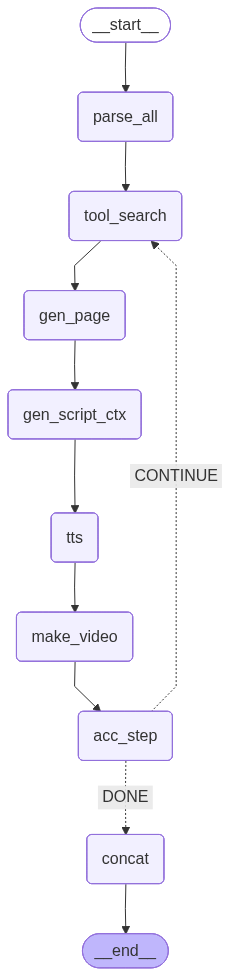

In [83]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

# ---- 노드 등록 ----
builder.add_node("parse_ppt", node_parse_all)
builder.add_node("tool_search", node_tool_search)
builder.add_node("gen_page_content", node_generate_page_content)
builder.add_node("gen_script", node_generate_script)
builder.add_node("tts", node_tts)
builder.add_node("make_video", node_make_video)
builder.add_node("accumulate", node_accumulate_and_step)
builder.add_node("concat", node_concat)
builder.add_node("make_quiz", node_generate_quiz)

# ✅ 조건 분기 라우터 등록
builder.add_conditional_edges(
    "accumulate",                    # 분기 기준 노드
    router_continue_or_done,         # 실행될 조건 함수
    {                                # 반환값에 따라 이동할 노드 지정
        "continue": "tool_search",   # 남은 슬라이드가 있을 때
        "done": "concat"             # 모든 슬라이드 완료 시
    }
)

# ---- 기본 흐름 연결 ----
builder.set_entry_point("parse_ppt")

builder.add_edge("parse_ppt", "tool_search")
builder.add_edge("tool_search", "gen_page_content")
builder.add_edge("gen_page_content", "gen_script")
builder.add_edge("gen_script", "tts")
builder.add_edge("tts", "make_video")
builder.add_edge("make_video", "accumulate")
builder.add_edge("concat", "make_quiz")
builder.add_edge("make_quiz", END)

# ---- 그래프 컴파일 ----
app = builder.compile()

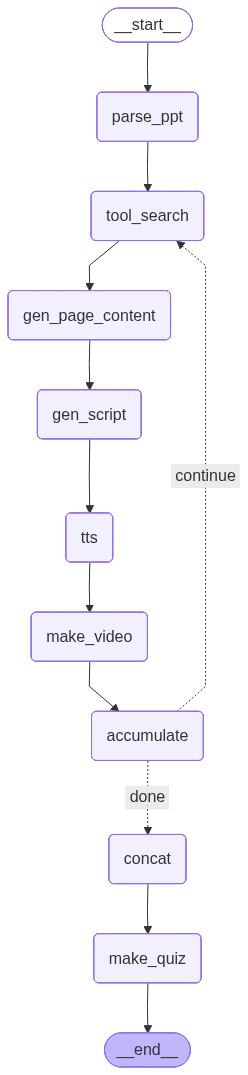

In [84]:
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## **4. 시스템 실행**

미션3,4에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 준비 작업
* 파일 업로드
* 사용자 프롬프트 준비

In [64]:
# 파일 업로드(sample2_test.pptx)
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample2_test.pptx to sample2_test.pptx


In [85]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "fable",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step1_output/"
MEDIA_DIR = os.path.join(WORK_DIR, "media")
SLIDES_DIR = os.path.join(WORK_DIR, "slides")

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)
os.makedirs(SLIDES_DIR, exist_ok=True)

### (2) Agent 실행
* State 초기화
* app 실행
    * 실행 시, 잘못된 반복 실행이 발생될 수 있으므로 다음 옵션 적용
        * `app.invoke(state, config={"recursion_limit": 100})`
        * 숫자 100은 조정 가능
* 동영상 play

In [86]:
state: State = {
    "pptx_path": pptx_path,              # 분석할 PPT 경로
    "work_dir": WORK_DIR,                # 출력 디렉터리
    "prompt": USER_PROMPT,               # 강의 톤, 음성 등 사용자 프롬프트
    "slide_index": 0,                    # 시작 슬라이드
}

In [87]:
state = app.invoke(state, config={"recursion_limit": 100})

총 3장의 슬라이드를 처리합니다.

=== 1번째 슬라이드 처리 중 ===
  [슬라이드 1] 제목: 모델 성능 모니터링
  → 텍스트 길이: 243 chars, 테이블: 0, 삽입 이미지: 1개, 도형: 0개

=== 2번째 슬라이드 처리 중 ===
  [슬라이드 2] 제목: ML 모델에 영향을 줄 수 있는 요인
  → 텍스트 길이: 166 chars, 테이블: 0, 삽입 이미지: 1개, 도형: 0개

=== 3번째 슬라이드 처리 중 ===
  [슬라이드 3] 제목: 모델 모니터링 아키텍처
  → 텍스트 길이: 163 chars, 테이블: 1, 삽입 이미지: 0개, 도형: 0개

=== 전체 슬라이드 처리 완료 ===
총 3장의 슬라이드 이미지 저장 완료.
--- 강의 스크립트 생성 중 ---
   [스크립트 생성 완료] (요청: 60초)
[TTS] 'fable' 보이스로 음성 생성 중...
[TTS] (1.0x) 생성된 MP3 길이: 67.1초
[완료] 슬라이드 1 → ./step1_output/slide1_lecture.mp4
슬라이드 1 완료: ./step1_output/slide1_lecture.mp4
 진행률: 1/1 (100.0%)
   성공: 1개 | 실패: 0개

CONTINUE: 남은 슬라이드 2개 (다음=1)

--- 강의 스크립트 생성 중 ---
   [스크립트 생성 완료] (요청: 60초)
[TTS] 'fable' 보이스로 음성 생성 중...
[TTS] (1.0x) 생성된 MP3 길이: 82.2초
[완료] 슬라이드 2 → ./step1_output/slide2_lecture.mp4
슬라이드 2 완료: ./step1_output/slide2_lecture.mp4
 진행률: 2/1 (200.0%)
   성공: 2개 | 실패: 0개

CONTINUE: 남은 슬라이드 1개 (다음=2)

--- 강의 스크립트 생성 중 ---
   [스크립트 생성 완료] (요청: 60초)
[TTS] 'fable' 보이스로 음성 생성 중...
[TTS] (1.0x)

In [88]:
import pprint
pprint.pprint(state)

{'all_scripts': ['모델 성능 모니터링은 머신 러닝 모델이 프로덕션 환경에서 어떻게 작동하는지를 지속적으로 추적하고 분석하는 '
                 '과정으로, 매우 중요합니다. 이 과정은 모델이 실제 환경에 배포된 후, 데이터나 환경의 변화로 인해 성능이 '
                 '저하될 수 있는 위험을 사전에 방지하는 역할을 합니다. \n'
                 '\n'
                 '화면의 표에서 확인하실 수 있듯이, 최근 14일 동안 총 1,820개의 예측을 진행했으며 그중 22개의 '
                 '이상치가 발견되었습니다. 이러한 이상치를 조기에 감지함으로써, 문제의 근본 원인을 분석하고 모델의 이해도를 '
                 '높일 수 있습니다. 이처럼 지속적인 모니터링은 데이터 과학자와 MLOps 실무자에게 중요한 가시성을 '
                 '제공하여, 머신 러닝 애플리케이션의 품질을 향상시키는 데 기여합니다. \n'
                 '\n'
                 '따라서, 모델 성능 모니터링은 단순한 기술적 필요성을 넘어, 머신 러닝의 신뢰성과 투명성을 높이는 중요한 '
                 '과정입니다. 이제 다음 슬라이드에서는 모델에 영향을 줄 수 있는 다양한 요인에 대해 살펴보겠습니다.',
                 'ML 모델에 영향을 미치는 요인 중 하나는 컨셉 변화(Concept Drift)입니다. 이는 시간이 지나면서 '
                 '데이터 변수나 패턴 간의 관계가 지속적으로 변화하는 현상을 의미합니다. 이러한 변화는 모델의 예측 성능에 '
                 '매우 큰 영향을 미칠 수 있는데, 예를 들어 COVID-19와 같은 예기치 않은 상황은 판매 패턴에 급격한 '
                 '변화를 가져올 수 있습니다. \n'
                

In [ ]:
# 파일 업로드(sample2.pptx)
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample2.pptx to sample2.pptx


In [ ]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "fable",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step2_output/"
MEDIA_DIR = os.path.join(WORK_DIR, "media")
SLIDES_DIR = os.path.join(WORK_DIR, "slides")

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)
os.makedirs(SLIDES_DIR, exist_ok=True)

In [ ]:
state: State = {
    "pptx_path": pptx_path,              # 분석할 PPT 경로
    "work_dir": WORK_DIR,                # 출력 디렉터리
    "prompt": USER_PROMPT,               # 강의 톤, 음성 등 사용자 프롬프트
    "slide_index": 0,                    # 시작 슬라이드
}

In [ ]:
state = app.invoke(state, config={"recursion_limit": 100})

총 7장의 슬라이드를 처리합니다.

=== 1번째 슬라이드 처리 중 ===
  [슬라이드 1] 제목: Model Monitoring
  → 텍스트 길이: 16 chars, 테이블: 0, 삽입 이미지: 0개

=== 2번째 슬라이드 처리 중 ===
  [슬라이드 2] 제목: 모델 성능 모니터링
  → 텍스트 길이: 243 chars, 테이블: 0, 삽입 이미지: 1개

=== 3번째 슬라이드 처리 중 ===
  [슬라이드 3] 제목: ML 모델에 영향을 줄 수 있는 요인
  → 텍스트 길이: 166 chars, 테이블: 0, 삽입 이미지: 1개

=== 4번째 슬라이드 처리 중 ===
  [슬라이드 4] 제목: ML 모델에 영향을 줄 수 있는 요인
  → 텍스트 길이: 109 chars, 테이블: 0, 삽입 이미지: 1개

=== 5번째 슬라이드 처리 중 ===
  [슬라이드 5] 제목: 모델 모니터링이 어려운 이유
  → 텍스트 길이: 188 chars, 테이블: 0, 삽입 이미지: 1개

=== 6번째 슬라이드 처리 중 ===
  [슬라이드 6] 제목: 모델 모니터링이 어려운 이유
  → 텍스트 길이: 192 chars, 테이블: 0, 삽입 이미지: 1개

=== 7번째 슬라이드 처리 중 ===
  [슬라이드 7] 제목: 모델 모니터링 아키텍처
  → 텍스트 길이: 163 chars, 테이블: 1, 삽입 이미지: 0개

=== 전체 슬라이드 처리 완료 ===
총 7장의 슬라이드 이미지 저장 완료.
--- 강의 스크립트 생성 중 ---
   [스크립트 생성 완료] (요청: 60초)
[TTS] 'fable' 보이스로 음성 생성 중...
[TTS] (1.0x) 생성된 MP3 길이: 72.0초
[완료] 슬라이드 1 → ./step2_output/slide1_lecture.mp4
슬라이드 1 완료: ./step2_output/slide1_lecture.mp4
 진행률: 1/1 (100.0%)
   성공: 1개 | 실패: 0개

CONTINUE: 남은 슬라이드 6개 (

## **5. Web APP 개발(Gradio)**
* 화면 개발
    * 입력 : ppt파일, 프롬프트(강의 작성톤), voice 선택(alloy, ...)
    * 출력 : 동영상 play, 동영상 다운로드 버튼
* 기본 화면을 제공합니다. 필요한 기능을 직접 추가하세요.

In [91]:
%%writefile app.py

import gradio as gr
import os, requests, time, shutil, re, textwrap, subprocess, json, base64, mimetypes, shlex
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, TypedDict, Any
from PIL import Image, ImageDraw
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from openai import OpenAI
from google.colab import files
from IPython.display import Audio, display, Video
from serpapi import GoogleSearch
from pptx.enum.shapes import PP_PLACEHOLDER
from urllib.parse import urlparse
import os.path as p, time
from langgraph.graph import StateGraph, END
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.cidfonts import UnicodeCIDFont
from difflib import SequenceMatcher

# 출력 dir 만들기
WORK_DIR = "./gradio1_output/"
MEDIA_DIR = os.path.join(WORK_DIR, "media")
SLIDES_DIR = os.path.join(WORK_DIR, "slides")

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)
os.makedirs(SLIDES_DIR, exist_ok=True)

def clean_text(s):
    return re.sub(r"\s+", " ", s).strip()

def split_sents(t: str) -> List[str]:
    parts = re.split(r'([\.?!])', t)
    merged = []
    for i in range(0, len(parts)-1, 2):
        sent = (parts[i] + parts[i+1]).strip()
        if sent: merged.append(sent)
    if len(parts) % 2 == 1 and parts[-1].strip():
        merged.append(parts[-1].strip())
    return [s for s in merged if s]

def ffprobe_duration(path: str) -> float:
    out = subprocess.check_output([
        "ffprobe","-v","error","-show_entries","format=duration",
        "-of","default=noprint_wrappers=1:nokey=1", path]).decode().strip()
    return float(out)

def img_to_data_url(path: str) -> str:
    mime = mimetypes.guess_type(path)[0] or "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

def render_mp4(image_path: str, audio_path: str, out_mp4: str,
               width=1920, height=1080, ):

    dur = ffprobe_duration(audio_path)

    vf = (f"scale={width}:{height}:force_original_aspect_ratio=decrease,"
          f"pad={width}:{height}:(ow-iw)/2:(oh-ih)/2:color=black"  )

    # FFmpeg 명령
    cmd = ["ffmpeg", "-y",
            "-loop", "1", "-i", image_path,   # 정지 이미지 입력
            "-i", audio_path,                 # 오디오 입력
            "-t", str(dur),                   # 길이 = 오디오 길이
            "-vf", vf,                        # 비디오 필터
            "-c:v", "libx264", "-preset", "veryfast", "-crf", "20",
            "-c:a", "aac", "-b:a", "192k",
            "-pix_fmt", "yuv420p",
            "-movflags", "+faststart",        # 웹/브라우저 재생 친화
            out_mp4]
    subprocess.check_call(cmd)  # 외부 프로그램(FFmpeg)을 파이썬 프로세스에서 실행하고, 성공했는지 확인

def export_slide_as_png(state: dict, dpi: int = 220) -> dict:
    work_dir = Path(state["work_dir"]).expanduser().resolve()
    work_dir.mkdir(parents=True, exist_ok=True)

    pptx = Path(state["pptx_path"]).expanduser().resolve()
    if not pptx.exists():
        raise FileNotFoundError(f"PPTX 없음: {pptx}")

    idx = int(state.get("slide_index", 0))  # 0-based
    page_no = idx + 1
    out_prefix = work_dir / "slide_img"

    env = os.environ.copy()
    env.update({
        "LANG": "ko_KR.UTF-8",
        "LC_ALL": "ko_KR.UTF-8",
    })

    # --- 1️⃣ PPT → PDF (한 번만 변환) ---
    pdf_path = work_dir / f"{pptx.stem}.pdf"
    if not pdf_path.exists():
        lo_cmd = [
            "soffice","--headless",
            "-env:UserInstallation=file:///tmp/lo_profile",
            "--convert-to","pdf:impress_pdf_Export",
            "--outdir", str(work_dir),
            str(pptx),
        ]
        res_pdf = subprocess.run(lo_cmd, capture_output=True, text=True, env=env)
        if res_pdf.returncode != 0:
            print("LibreOffice 변환 실패")
            print("stdout:", res_pdf.stdout)
            print("stderr:", res_pdf.stderr)
            raise RuntimeError("PPTX → PDF 변환 실패")

    # --- 2️⃣ PDF → PNG (슬라이드별 추출) ---
    png_path = work_dir / f"{out_prefix.stem}-{page_no}.png"
    ppm_cmd = [
        "pdftoppm",
        "-f", str(page_no),
        "-l", str(page_no),
        "-png", "-r", str(dpi),
        str(pdf_path),
        str(out_prefix)
    ]
    res2 = subprocess.run(ppm_cmd, capture_output=True, text=True, env=env)
    if res2.returncode != 0:
        print("pdftoppm 변환 실패:", res2.stderr)

    if not png_path.exists():
        raise FileNotFoundError(f"슬라이드 {page_no} PNG 변환 실패")

    # --- 3️⃣ 변환 후 PDF 삭제 ---
    try:
        if pdf_path.exists():
            os.remove(pdf_path)
            # print(f"PDF 삭제 완료: {pdf_path.name}")
    except Exception as e:
        print(f"[경고] PDF 삭제 실패: {e}")

    # --- 4️⃣ 최종 PNG 경로 반환 ---
    state["slide_image"] = str(png_path)
    return state

def concat_videos_ffmpeg(video_paths: List[str], out_path: str, reencode: bool=False):
    list_path = out_path + ".txt"
    with open(list_path, "w", encoding="utf-8") as f:
        for v in video_paths:
            f.write(f"file '{os.path.abspath(v)}'\n")
    if reencode:
        cmd = [
            "ffmpeg","-y","-safe","0","-f","concat","-i",list_path,
            "-vf","format=yuv420p",
            "-c:v","libx264","-preset","veryfast",
            "-c:a","aac","-b:a","192k",
            out_path
        ]
    else:
        cmd = ["ffmpeg","-y","-safe","0","-f","concat","-i",list_path,"-c","copy",out_path]
    subprocess.check_call(cmd)

# State 정의 및 초기화
class State(TypedDict, total=False): # total=False는 TypedDict에서 모든 키를 선택(optional)으로 취급
  # 입력/기본
  pptx_path: str
  work_dir: str
  prompt: Dict  # -> 내부추가 speed, + 변경 : voice 후보
  slide_index: int

  # 추출 산출물
  titles: List[str] # -> 추가 : 슬라이드 제목
  texts: List[str]
  tables: List[List[List[str]]]
  images: List[str]
  shape_texts: List[str]
  slide_image: List[str]
  external_content: Dict[str, List[Dict[str, str]]] # -> 추가 (외부 지식)

  # 생성 산출물
  page_content: str
  script: str
  all_scripts: List[str] # -> 추가 : 퀴즈 노드를 위해 스크립트 저장
  quiz_set: List[Dict[str, Any]] # -> 추가 : 퀴즈 노드가 생성한 퀴즈 -> 수정: List[Dict[str, Any]]

  # 미디어 산출물
  audio: str
  video_path: List[str] # 변경 : str -> List[str]

  video_paths: List[str]     # 생성된 영상 path 리스트
  final_video: str           # 최종 합쳐진 영상 path

def get_shapes_text(shape):
    """하나의 도형(또는 그룹)에서 텍스트를 재귀적으로 추출"""
    texts = []
    if shape.shape_type == MSO_SHAPE_TYPE.GROUP:
        for sh in shape.shapes:
            texts.extend(get_shapes_text(sh))
    elif shape.shape_type == MSO_SHAPE_TYPE.AUTO_SHAPE and shape.has_text_frame:
        text = shape.text.strip()
        if text:
            texts.append(text)
    return texts

def node_parse_all(state: State) -> State:
    ppt = Presentation(state['pptx_path'])
    work_dir = state.get("work_dir", "./")

    # ✅ 전역 경로 참조 (바깥에서 이미 지정됨)
    global SLIDES_DIR, MEDIA_DIR
    slides_dir = SLIDES_DIR
    media_dir = MEDIA_DIR

    texts = []
    tables = []
    images = []
    titles = []
    slide_image = []
    shapes = []

    print(f"총 {len(ppt.slides)}장의 슬라이드를 처리합니다.")

    for slide_idx, slide in enumerate(ppt.slides):
            print(f"\n=== {slide_idx+1}번째 슬라이드 처리 중 ===")

            full_slide_text = ""
            slide_tables = []
            slide_images = []
            slide_title = ""
            slide_shapes_texts = []  # ✅ 슬라이드별 도형 텍스트 임시 저장


            # ✅ 슬라이드 전체 이미지 변환 (slides 폴더)
            slide_state = {
                "pptx_path": state['pptx_path'],
                "work_dir": slides_dir,  # 전역 폴더 사용
                "slide_index": slide_idx
            }
            slide_state = export_slide_as_png(slide_state)

            src_path = slide_state["slide_image"]
            dst_path = os.path.join(slides_dir, f"slide_img{slide_idx+1}.png")

            if os.path.exists(src_path):
                os.replace(src_path, dst_path)
                slide_image.append(dst_path)
            else:
                print(f"[경고] 슬라이드 {slide_idx+1} PNG가 존재하지 않습니다: {src_path}")
                slide_image.append(None)

            for shape_idx, sh in enumerate(slide.shapes):
                if sh.is_placeholder and sh.placeholder_format.type == PP_PLACEHOLDER.TITLE:
                    if sh.has_text_frame:
                        title_text = sh.text.strip()
                        print(f"  [슬라이드 {slide_idx+1}] 제목: {title_text}")
                        slide_title = title_text

                if sh.has_text_frame:
                    txt = "\n".join(p.text for p in sh.text_frame.paragraphs)
                    full_slide_text += txt + "\n"

                if sh.shape_type == MSO_SHAPE_TYPE.TABLE:
                    tbl = [[c.text.strip() for c in r.cells] for r in sh.table.rows]
                    slide_tables.append(tbl)
                #도형이랑 그룹 같이 확인
                slide_shapes_texts.extend(get_shapes_text(sh))

                if sh.shape_type == MSO_SHAPE_TYPE.PICTURE:
                    ext = sh.image.ext
                    img_filename = f"slide{slide_idx+1}_img_{len(slide_images)}.{ext}"
                    path = os.path.join(media_dir, img_filename)
                    slide_images.append(path)
                    with open(path, "wb") as f:
                        f.write(sh.image.blob)

            # ==================== 슬라이드별 정보 누적 ====================
            texts.append(full_slide_text.strip())
            tables.append(slide_tables)
            images.append(slide_images)
            titles.append(slide_title)

            # ✅ 슬라이드별 도형 텍스트를 ','로 묶어 하나의 문자열로 추가
            shapes.append(",".join(slide_shapes_texts))

            print(f"  → 텍스트 길이: {len(full_slide_text.strip())} chars, 테이블: {len(slide_tables)}, 삽입 이미지: {len(slide_images)}개, 도형: {len(slide_shapes_texts)}개")

    print("\n=== 전체 슬라이드 처리 완료 ===")
    print(f"총 {len(ppt.slides)}장의 슬라이드 이미지 저장 완료.")

    # ✅ 결과 state에 저장
    state['texts'] = texts
    state['tables'] = tables
    state['images'] = images
    state['slide_image'] = slide_image
    state['titles'] = titles
    state['shape_texts'] = shapes

    # ✅ 여기에 추가!
    state["total_slides"] = len(ppt.slides)

    return state

def serpapi_search_by_title(title: str, num: int = 4) -> list[dict]:
    """SerpAPI를 이용해 실제 검색을 수행하고 결과를 반환 (비공식 출처 제외)"""
    key = os.getenv("SERPAPI_API_KEY")

    # 제외할 도메인 리스트
    EXCLUDE_DOMAINS = [
        "blog.naver.com", "m.blog.naver.com", "tistory.com",
        "brunch.co.kr", "medium.com", "velog.io",
        "kin.naver.com", "reddit.com", "youtube.com"
    ]

    # 검색 요청
    query = f"{title} " + " ".join([f"-site:{d}" for d in EXCLUDE_DOMAINS])
    res = requests.get("https://serpapi.com/search.json", params={
        "engine": "google",
        "q": query,
        "hl": "ko",
        "gl": "kr",
        "num": num,
        "api_key": key
    }, timeout=15)

    # 결과 필터링
    data = res.json().get("organic_results", []) or []
    results = []
    for item in data:
        url = item.get("link", "")
        if not url:
            continue
        domain = urlparse(url).netloc
        if any(ex in domain for ex in EXCLUDE_DOMAINS):
            continue
        results.append({
            "title": item.get("title", ""),
            "url": url,
            "snippet": item.get("snippet", ""),
            "domain": domain
        })
    return results

def node_tool_search(state: dict) -> dict:
    """
    외부 검색 노드
    - slide_index 기반으로 title/text/table/image를 읽음
    - 질의 생성 후 serpapi_search_by_title 호출
    - 결과를 state['external_content']에 저장
    """
    state["external_content"] = {"queries": [], "summaries": [], "references": []} # 초기화
    idx = state.get("slide_index", 0)
    titles = state.get("titles", [])
    texts_all = state.get("texts", [])
    tables_all = state.get("tables", [])
    images_all = state.get("images", [])

    title = titles[idx] if idx < len(titles) else ""
    texts = texts_all[idx] if idx < len(texts_all) else ""
    tables = tables_all[idx] if idx < len(tables_all) else []
    images = images_all[idx] if idx < len(images_all) else []

    # 질의 생성
    queries = []
    if title: queries.append({"text": title, "context": "title"})
    if title and texts: queries.append({"text": f"{title} {texts[:80]}", "context": "title+text"})
    if title and tables and tables[0] and tables[0][0]:
        head = " ".join(map(str, tables[0][0][:5]))
        queries.append({"text": f"{title} {head}", "context": "title+table"})
    if title and images:
        names = " ".join([p.splitext(p.basename(x))[0] for x in images[:2]])
        queries.append({"text": f"{title} {names}", "context": "title+image"})
    if not queries and texts:
        queries.append({"text": texts[:100], "context": "text_only"})

    # 검색 수행
    all_results = []
    for q in queries:
        results = serpapi_search_by_title(q["text"], num=4)
        all_results.extend(results)
        time.sleep(0.2)

    # ===== 일관성/신뢰도 필터: 유사 스니펫 2+ & 서로 다른 도메인 2+ =====
    def norm(s: str) -> str: # 문자열 표준화 함수
        s = (s or "").lower().strip()
        s = re.sub(r"\s+", " ", s)
        return s

    def similar(a: str, b: str, thr: float = 0.82) -> bool: # 문자열 유사도 측정 함수
        return bool(a and b) and SequenceMatcher(None, norm(a), norm(b)).ratio() >= thr

    groups = []  # 각 그룹: {"rep": str, "items": [dict], "domains": set}
    for r in all_results: # 그룹을 순회하며 유사 내용끼리 하나의 그룹으로 통합
        snip, dom = r.get("snippet",""), r.get("domain","")
        if not snip:
            continue
        placed = False
        for g in groups:
            if similar(snip, g["rep"]):
                g["items"].append(r)
                if dom: g["domains"].add(dom)
                placed = True
                break
        if not placed:
            groups.append({"rep": snip, "items": [r], "domains": set([dom] if dom else [])})

    # 채택: 스니펫 2개 이상 & 도메인 2개 이상
    picked = [g for g in groups if len(g["items"]) >= 2 and len(g["domains"]) >= 2]
    if not picked:  # 폴백 (채택되지 않았을 경우)
        summaries = [{"text": r["snippet"], "source": r["title"]} for r in all_results if r.get("snippet")]
        references = [{"title": r["title"], "url": r["url"]} for r in all_results]
    else:
        summaries, references, seen_dom = [], [], set()

        # 채택된 그룹 처리 - 정렬: 도메인 수, 아이템 수
        picked.sort(key=lambda g: (len(g["items"]), len(g["domains"])), reverse=True)
        for g in picked:
            # Summaries: 그룹의 대표 스니펫을 하나만 추가
            top = g["items"][0]
            summaries.append({"text": top.get("snippet",""), "source": top.get("title","")})

            # References: 그룹 내 도메인별로 대표 아이템을 하나만 선정
            dom_pick = {}
            for item in g["items"]:
                domain = item.get("domain")
                # 해당 도메인의 첫 번째 아이템을 대표로 저장 (후순위 아이템은 무시)
                if domain and domain not in dom_pick:
                    dom_pick[domain] = {"title": item.get("title",""), "url": item.get("url","")}

            # 전체 출처 목록에 중복 없이 추가
            for domain, ref in dom_pick.items():
                # 이미 다른 그룹에서 사용된 도메인은 건너뛰고, 새로운 도메인만 추가
                if domain not in seen_dom:
                    seen_dom.add(domain)
                    references.append(ref)

    # 결과 정리
    summaries = [{"text": r["snippet"], "source": r["title"]}
                 for r in all_results if r["snippet"]]
    references = [{"title": r["title"], "url": r["url"]}
                  for r in all_results]

    state["external_content"] = {
        "queries": queries,
        "summaries": summaries,
        "references": references
    }
    return state

LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"
client = OpenAI()

def node_generate_page_content(state: State) -> State:
    """
    슬라이드 인덱스 기준으로 해당 슬라이드 내용만 사용.
    - 텍스트는 항상 문자열로 처리.
    - 외부 보완 자료(external_content) 통합 후 요약 생성.
    """
    # (1) 인덱스 및 데이터 선택
    idx        = int(state.get("slide_index", 0))
    titles     = state.get("titles", [])
    texts_all  = state.get("texts", [])
    tables_all = state.get("tables", [])
    images_all = state.get("images", [])
    shapes_all = state.get("shapes", [])

    title  = clean_text(str(titles[idx])) if idx < len(titles) else ""
    texts  = clean_text(str(texts_all[idx])) if idx < len(texts_all) else ""
    tables = tables_all[idx] if idx < len(tables_all) else []
    images = images_all[idx] if idx < len(images_all) else []
    shapes = shapes_all[idx] if idx < len(shapes_all) else []
    prompt = clean_text(str(state.get("prompt", "")))

    # (2) 표 전처리: 첫 표 최대 6행만 문자열로
    table_text = ""
    if tables and isinstance(tables, list) and len(tables) > 0:
        first_table = tables[0][:6] if isinstance(tables[0], list) else []
        table_text = "\n".join([" | ".join(map(str, row)) for row in first_table])

    # (3) 이미지 인코딩 (최대 3장)
    image_data_urls = []
    for img_path in images[:3]:
        try:
            image_data_urls.append(img_to_data_url(img_path))
        except Exception:
            continue

    # (4) 도형 전처리
    shapes_text = ""
    if isinstance(shapes, list) and len(shapes) > 0:
        lines = []
        for sh in shapes[:6]:
            if isinstance(sh, dict):
                t  = str(sh.get("type", "")).strip()
                nm = str(sh.get("name", "")).strip()
                tx = str(sh.get("text", "")).strip()
                # 한 줄 요약
                if t or nm or tx:
                    lines.append(f"- {t or 'shape'} {f'[{nm}]' if nm else ''} {f': {tx[:60]}' if tx else ''}".rstrip())
                else:
                    lines.append(f"- {str(sh)[:60]}")
            else:
                # 문자열/기타 타입은 그대로 요약
                lines.append(f"- {str(sh)[:60]}")
        shapes_text = "\n".join(lines)

    # (5) 외부 보완 데이터
    ext = state.get("external_content", {}) or {}
    ext_queries   = ext.get("queries", [])
    ext_summaries = ext.get("summaries", [])
    ext_refs      = ext.get("references", [])

    # (6) 외부 보완 블록 구성
    ext_ref_block = ""
    if ext_refs:
        cites = [
            f"[{i+1}] {clean_text(r.get('title',''))[:100]} — {r.get('url','')}"
            for i, r in enumerate(ext_refs[:4])
        ]
        ext_ref_block = "\n".join(cites)

    ext_summary_block = ""
    if ext_summaries:
        summ_lines = [
            f"- {clean_text(s.get('text',''))} ({s.get('source','')})"
            for s in ext_summaries[:3]
        ]
        ext_summary_block = "\n".join(summ_lines)

    # (7) 프롬프트 구성
    content_input = (
        f"다음은 한 슬라이드의 정보와 외부 보완 자료입니다.\n"
        f"제목: {title}\n"
        f"---\n"
        f"[텍스트]\n{texts}\n\n"
        f"[표 (앞 6행)]\n{table_text}\n\n"
        f"[도형(요약)]\n{shapes_text}\n\n"
        f"[프롬프트 지침]\n{prompt}\n"
        f"---\n"
        f"타입별 해석 포인트:\n"
        f"- 텍스트: 주요 용어 정의, 핵심 문장, 강조된 개념을 파악합니다.\n"
        f"- 표(Table): 비교 기준과 각 항목 간의 차이점, 우위·열위 포인트를 추출합니다.\n"
        f"- 그래프(Chart): 수치의 변화 추세, 증가·감소 구간, x축과 y축 간의 인과관계를 분석합니다.\n"
        f"- 이미지(Image): 그림/도형 내의 핵심 텍스트와 주요 객체, 관계를 파악합니다.\n"
        f"- 코드(Code): 입력·처리·출력 단계의 흐름과 목적, 핵심 프로세스를 요약합니다.\n"
        f"---\n"
        f"[외부 보완 자료]\n"
        f"- 생성 질의: {ext_queries[:3]}\n"
        f"- 핵심 보강 요약:\n{ext_summary_block}\n"
        f"- 참조 출처:\n{ext_ref_block}\n"
        f"---\n"
        f"규칙:\n"
        f"1) 과장 금지, 객관적으로 요약할 것.\n"
        f"2) 4~6문장, 문단 형태(불릿 금지).\n"
        f"3) 이미지/표/도형 의미를 자연스럽게 통합해 설명.\n"
        f"4) 외부 보완 내용은 핵심만 반영하되, 출처를 대괄호 숫자로 표시 (예: [1][2]).\n"
    )

    # (7) LLM 호출
    messages = [
        {
            "role": "system",
            "content": "당신은 슬라이드의 텍스트와 이미지, 표, 그래프 등을 바탕으로 강의 내용을 생성하고 신뢰할 수 있는 외부 자료로 보완하는 전문 강사입니다."
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": content_input}]
        }
    ]
    for img_url in image_data_urls:
        messages[-1]["content"].append({"type": "image_url", "image_url": {"url": img_url}})

    response = client.chat.completions.create(model=LLM_MODEL, messages=messages)

    # (8) 결과 저장
    page_content = clean_text(response.choices[0].message.content)
    state["page_content"] = " ".join(split_sents(page_content))
    return state

def node_generate_script(state: State) -> State:
    """
    모든 맥락(목차, 이전 스크립트, RAG, 퀴즈, 요청 시간)을 고려하여 스크립트를 생성
    """
    print("--- 강의 스크립트 생성 중 ---")

    # --- 1. State에서 모든 재료 가져오기 ---

    # (정보 분해 파트)
    all_titles = state.get("titles", [])



    # (이전 스크립트)
    prev_scripts = state.get("all_scripts", [])
    previous_script = prev_scripts[-1] if prev_scripts else "없음" # 직전 스크립트

    # (프롬프트)
    prompt_data = state.get("prompt", {})
    tone = prompt_data.get("tone", "친절하고 명료한 톤")
    target_time = prompt_data.get("target_duration_sec", 60) # 시간 조정

    # (페이지 내용/RAG 파트)
    current_page_content = state.get("page_content", "")
    # external_content = state.get("external_content", {})

    # (RAG 결과 포맷팅)
    # formatted_rag = format_external_content(external_content)

    work_dir = state.get("work_dir", "./")

    # [수정] 슬라이드 위치 파악
    current_index = state.get("slide_index", 0)
    total_slides = len(all_titles)

    flow_instruction = ""
    if current_index == 0:
        # 1. 첫 번째 슬라이드
        flow_instruction = "이것은 전체 강의의 '첫 번째' 슬라이드입니다. 강의 전체를 소개하는 '도입부'로 시작하되, 청중에게 직접적인 인사말(예: 안녕하세요, 반갑습니다)은 넣지 말아 주세요. 하나의 긴 강의가 시작되는 것처럼 자연스럽게 시작해야 합니다. (이전 내용 요약/마무리 인사는 금지)"
    elif current_index == total_slides - 1:
        # 2. 마지막 슬라이드
        flow_instruction = "이것은 전체 강의의 '마지막' 슬라이드입니다. 강의 전체를 요약하고 청중에게 '마무리 끝인사'를 반드시 포함해 주세요. (다음 내용 예고 금지)"
    else:
        # 3. 중간 슬라이드
        flow_instruction = "이것은 강의의 '중간' 슬라이드입니다. 직전 슬라이드 스크립트의 마지막 문장(예: '{previous_script[-50:]}')에서 내용이 '완벽하게 연결'되도록 현재 슬라이드의 설명을 바로 시작해 주세요. 별도의 연결 멘트 없이 바로 본론을 시작하며, 하나의 긴 강의처럼 흐름을 유지해야 합니다. (이전 내용 요약 및 다음 내용 예고 금지)"
    current_title = all_titles[current_index] if all_titles else "현재 슬라이드"

   # --- 2. LLM 프롬프트 설계 ---

    system_prompt = (
        "당신은 전문 AI 강사입니다. 이 스크립트는 여러 슬라이드를 연결하여 제작될 '하나의 연속적인 강의 영상'에 사용될 것입니다. "
        "강의의 전체 목차와 흐름을 고려하여, 모든 슬라이드 스크립트가 끊김 없이 매끄럽게 이어지도록 작성해야 합니다."
    )

    user_prompt = f"""
    # 전체 강의 목차
    {all_titles}

    # 현재 강의 중인 슬라이드
    - 인덱스: {current_index}
    - 제목: {current_title}

    # 직전 슬라이드 스크립트
    {previous_script}

    #현재 슬라이드 핵심 내용
    {current_page_content}

    # 필수) 스크립트 작성 조건
    1. 톤앤매너: {tone}
    2. 분량: 약 {target_time}초 분량의 스크립트를 작성해 주세요.
    3. [중요] 흐름 지시사항: {flow_instruction}
    4. [연속성 규칙] '오늘', '이번 강의에서는', '안녕하세요', '마지막으로', '감사합니다' 등 강의의 연속성을 끊거나 시간/날짜를 특정하는 표현은 마지막 슬라이드의 최종 끝인사를 제외하고는 **절대 사용하지 마세요.**
    5. [생동감] 청중의 이해를 돕기 위해 현재 슬라이드의 내용 중 중요한 부분이나 그래프/이미지를 언급하며 '청중에게 말을 거는 듯한' 구어체와 생동감을 불어 넣어주세요.
    6. [근거 제시] 슬라이드에 제시된 데이터(그래프, 표, 수치)나 검색된 외부 정보(예: Amazon SageMaker)를 언급할 때는 "화면의 그래프에서", "이 표에서 확인하실 수 있듯이", "Amazon SageMaker와 같은 플랫폼을 예로 들면" 등의 표현으로 근거를 제시하며 설명해 주세요.

    [스크립트 시작]
    """

    # (3) LLM 호출
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.7,
    )

    script = response.choices[0].message.content \
    .replace("[스크립트 시작]", "") \
    .replace("[스크립트 종료]", "") \
    .strip()
    print(f"   [스크립트 생성 완료] (요청: {target_time}초)")
    state["script"] = script

    if "all_scripts" not in state:
      state["all_scripts"] = []
    state["all_scripts"].append(script)

    # (4) 파일 저장
    os.makedirs(work_dir, exist_ok=True)
    script_path = os.path.join(work_dir, f"script_{current_index}.txt")
    with open(script_path, "w", encoding="utf-8") as f:
        f.write(script)

    return state

def node_tts(state: dict) -> dict:
    """
    발표 스크립트를 음성(mp3)으로 변환하고 state에 저장
    입력:
        state["script"] - 발표 대본 텍스트
        state["prompt"]["voice"] - 선택적, 목소리 프리셋 (기본 'alloy')
        state["prompt"]["speed"] - 선택적, 재생 속도 (기본 1.0)
        state["work_dir"] - 저장 디렉토리
    출력:
        state["audio"] - mp3 파일 경로
        콘솔 출력 - mp3 길이(sec)
    """

    # (1) 입력 불러오기
    script = state.get("script", "")
    prompt = state.get("prompt", {}) or {}
    voice = prompt.get("voice", "중립적이고 깨끗한 목소리 -alloy")
    work_dir = state.get("work_dir", "./")
    speed = prompt.get("speed", 1.0)  # 새로 추가된 옵션 (기본 1배속)
    slide_idx = int(state.get("slide_index", 0))  # ✅ 슬라이드 번호 추가

    # '기업·기술·세미나용 -onyx' → 'onyx'
    voice = voice.split('-')[-1].strip()

    if not script.strip():
        raise ValueError("state['script']가 비어 있습니다. 먼저 대본을 생성하세요.")

    # (2) 저장 경로 준비
    os.makedirs(work_dir, exist_ok=True)
    # 수정
    base_audio_path = os.path.join(work_dir, f"narration_raw_{slide_idx}.mp3")
    final_audio_path = os.path.join(work_dir, f"narration_{slide_idx}_{speed}x.mp3")

    # (3) OpenAI TTS 호출
    print(f"[TTS] '{voice}' 보이스로 음성 생성 중...")
    response = client.audio.speech.create(
        model=TTS_MODEL,
        voice=voice,
        input=script,
        response_format="mp3"
    )

    # (4) 원본 파일 저장
    with open(base_audio_path, "wb") as f:
        f.write(response.read())

    # (5) ffmpeg를 이용해 속도 조절 (기본 1.0x면 그대로 사용)
    if speed != 1.0:
        print(f"[FFmpeg] {speed}배속 변환 중...")
        cmd = [
            "ffmpeg", "-y", "-i", base_audio_path,
            "-filter:a", f"atempo={speed}",
            "-b:a", "192k",
            final_audio_path
        ]
        subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    else:
        final_audio_path = base_audio_path

    # (6) ffprobe_duration() 활용해 길이 출력
    duration = ffprobe_duration(final_audio_path)
    print(f"[TTS] ({speed}x) 생성된 MP3 길이: {round(duration, 1)}초")

    # (7) state에 경로 저장
    state["audio"] = final_audio_path

    return state

def node_make_video(state: dict) -> dict:
    """
    영상 제작
    - 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
    입력:
        state["slide_image"][0] : 첫 번째 슬라이드 이미지 경로
        state["audio"] : mp3 오디오 경로
        state["work_dir"] : 저장 디렉토리
        state["slide_index"] : 슬라이드 번호
    출력:
        state["video_path"] : 생성된 mp4 경로
    """

    slide_imgs = state.get("slide_image", [])
    audio_path = state.get("audio", "")
    work_dir = state.get("work_dir", "./")
    slide_index = state.get("slide_index", 0)

    if not slide_imgs or slide_index >= len(slide_imgs):
        print(f"[경고] 처리할 슬라이드가 없습니다. (index={slide_index})")
        return state
    if not os.path.exists(audio_path):
        raise FileNotFoundError("오디오 파일을 찾을 수 없습니다.")

    # ✅ 여기에 추가!!
    if "video_path" not in state:
        state["video_path"] = []

    os.makedirs(work_dir, exist_ok=True)
    video_filename = f"slide{slide_index+1}_lecture.mp4"
    out_mp4 = os.path.join(work_dir, video_filename)

    # 실제 영상 생성
    render_mp4(
        image_path=slide_imgs[slide_index],
        audio_path=audio_path,
        out_mp4=out_mp4
    )

    # ✅ 중복 방지 추가
    if out_mp4 not in state["video_path"]:
        state["video_path"].append(out_mp4)

    print(f"[완료] 슬라이드 {slide_index+1} → {out_mp4}")

    return state

def node_accumulate_and_step(state: dict) -> dict:
    """
    영상 생성 후 현재 상태를 파악하고 다음 처리 준비
    - 생성된 영상 확인 및 저장
    - 슬라이드 인덱스 증가
    - 진행 상황 출력
    """
    current_idx = state.get("slide_index", 0)
    total = state.get("total_slides", 1)
    video_list = state.get("video_path", [])

    # ✅ 누적 리스트 초기화 (최초 1회만)
    if "video_paths" not in state or not isinstance(state["video_paths"], list):
        state["video_paths"] = []

    # 1️⃣ 영상 검증 및 누적
    if len(video_list) > current_idx:
        current_video = video_list[current_idx]
        if os.path.exists(current_video):
            if current_video not in state["video_paths"]:  # ✅ 중복 방지
                state["video_paths"].append(current_video)
            print(f"슬라이드 {current_idx+1} 완료: {current_video}")
        else:
            if "failed_slides" not in state:
                state["failed_slides"] = []
            state["failed_slides"].append(current_idx)
            print(f"슬라이드 {current_idx+1} 실패")
    else:
        print(f"[경고] 인덱스 초과: {current_idx} / {len(video_list)}")

    # 2️⃣ 다음 슬라이드로 이동
    state["slide_index"] = current_idx + 1

    success_count = len(state.get("video_paths", []))
    fail_count = len(state.get("failed_slides", []))
    progress = (state["slide_index"] / total) * 100
    print(f" 진행률: {state['slide_index']}/{total} ({progress:.1f}%)")
    print(f"   성공: {success_count}개 | 실패: {fail_count}개")

    return state

def router_continue_or_done(state: dict) -> str:
    current_idx = state.get("slide_index", 0) - 1
    total_slides = state.get("total_slides", len(state.get("titles", [])))

    # ✅ 조건 수정
    if current_idx >= total_slides - 1:
        success_count = len(state.get("video_paths", []))
        fail_count = len(state.get("failed_slides", []))
        print(f"DONE: 모든 슬라이드 처리 완료!")
        print(f"   성공: {success_count}개 | 실패: {fail_count}개\n")
        return "done"
    else:
        remaining = total_slides - (current_idx + 1)
        print(f"\nCONTINUE: 남은 슬라이드 {remaining}개 (다음={current_idx+1})\n")
        return "continue"

def node_concat(state: State) -> State:
    """
    video_paths의 모든 영상을 순서대로 연결
    """
    video_paths = state.get("video_paths", [])
    work_dir = state.get("work_dir", "./step1_output")

    if not video_paths:
        print(" 합칠 영상이 없습니다.")
        return state

    print(f"영상 합치기 시작")
    print(f"파일 개수: {len(video_paths)}개\n")

    # 각 영상 정보 출력
    for i, path in enumerate(video_paths):
        duration = ffprobe_duration(path)
        print(f"  {i}. {os.path.basename(path)} ({duration:.1f}초)")

    # 최종 영상 경로
    final_video = os.path.join(work_dir, "final_lecture.mp4")

    # FFmpeg로 영상 합치기
    print(f"\n FFmpeg 처리 중...")
    concat_videos_ffmpeg(
        video_paths=video_paths,
        out_path=final_video,
        reencode=False  # 빠른 복사 방식
    )

    # State 업데이트
    state["final_video"] = final_video

    # 최종 결과 정보
    total_duration = ffprobe_duration(final_video)
    file_size = os.path.getsize(final_video) / (1024 * 1024)  # MB


    print(f" 최종 영상 생성 완료!")
    print(f" 경로: {final_video}")
    print(f" 총 재생 시간: {int(total_duration//60)}분 {int(total_duration%60)}초")
    print(f"  파일 크기: {file_size:.2f} MB")

    # 실패 슬라이드 리포트 (있는 경우)
    failed = state.get("failed_slides", [])
    if failed:
        print(f"\n 실패한 슬라이드: {failed}")


    return state

def node_generate_quiz(state: dict) -> dict:
    """
    퀴즈 생성 노드
    - 모든 슬라이드의 스크립트가 끝난 후, 전체 내용을 바탕으로 퀴즈를 생성합니다.
    - Gradio 호환을 위해 List[Dict] JSON 형식으로 결과를 반환합니다.
    - 퀴즈는 question, options, answer 키만 포함합니다.
    """

    # (1) 입력 불러오기
    all_scripts = state.get("all_scripts", [])

    if not all_scripts:
        print("퀴즈를 생성할 스크립트가 없습니다.")
        state["quiz_set"] = [{"question": "스크립트 없음", "options": [], "answer": ""}]
        return state

    # (2) 시스템 및 사용자 프롬프트 구성 (JSON 출력 형식)
    system_prompt = textwrap.dedent("""
        당신은 강의 내용을 복습시키는 전문 교육 보조입니다.
        제공된 강의 스크립트 전체 내용을 바탕으로,
        핵심 내용을 확인할 수 있는 퀴즈 세트를 생성해야 합니다.
        퀴즈는 반드시 객관식 4지선다형이어야 하며,
        강의의 핵심 개념을 다루어야 합니다.
        **반드시 유효한 JSON 형식으로만 응답해야 합니다.**
    """)

    full_lecture_script = "\n\n".join(
        [f"[슬라이드 {i+1}]\n{script}" for i, script in enumerate(all_scripts)]
    )

    # JSON 형식과 객관식 4지선다형
    user_prompt = textwrap.dedent(f"""
        다음은 방금 완료된 전체 강의 스크립트입니다.

        --- [강의 전체 내용] ---
        {full_lecture_script}
        ---

        [규칙]
        1. 위 강의 내용 전체를 바탕으로 **총 6개의 [객관식 퀴즈]**를 생성하세요.
        2. 각 퀴즈는 반드시 4개의 선택지(options)를 가져야 합니다.
        3. **[중요]** 각 선택지는 **'1. 선택지 내용', '2. 선택지 내용'** 처럼 반드시 번호로 시작해야 합니다.
        4. 각 퀴즈마다 [질문(question)], [선택지(options)], [정답(answer)] 키만 포함해야 합니다.
        5. **[중요]** 정답(answer)은 **번호가 포함된 선택지 텍스트와 정확히 일치**해야 합니다. (예: "1. 선택지 1")
        6. **[가장 중요]** 출력은 반드시 다음 [JSON 형식 예시]를 정확하게 따르는 **단일 JSON 배열**이어야 합니다.

        --- [JSON 형식 예시] ---
        [
          {{
            "question": "첫 번째 객관식 질문 내용입니다.",
            "options": [
              "1. 선택지 1",
              "2. 선택지 2",
              "3. 선택지 3",
              "4. 선택지 4"
            ],
            "answer": "1. 선택지 1"
          }},
          {{
            "question": "두 번째 객관식 질문 내용입니다.",
            "options": [
              "1. 선택지 A",
              "2. 선택지 B",
              "3. 선택지 C",
              "4. 선택지 D"
            ],
            "answer": "3. 선택지 C"
          }}
        ]
        ---
    """)

    # (3) LLM 호출
    try:
        response = client.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            response_format={"type": "json_object"} # JSON 모드 활성화
        )
        quiz_set_json_string = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[오류] LLM 호출에 실패했습니다: {e}")
        state["quiz_set"] = [{"question": "LLM 호출 오류", "options": [], "answer": ""}]
        return state

    # (4) State 저장 (JSON 파싱)
    try:
        quiz_set_list = json.loads(quiz_set_json_string)
        # quiz_set 키에 바로 리스트를 할당
        state["quiz_set"] = quiz_set_list.get("quizzes", quiz_set_list) # 혹시 LLM이 'quizzes' 키로 감쌀 경우 대비

        print(f"  [퀴즈 생성 완료] 총 {len(state['quiz_set'])}개의 퀴즈가 JSON 형식으로 생성되었습니다.")
    except json.JSONDecodeError:
        print(f"[오류] LLM이 유효한 JSON을 반환하지 않았습니다. 텍스트로 저장합니다.")
        print(f"LLM Output: {quiz_set_json_string}")
        state["quiz_set"] = [{"question": "JSON 파싱 오류", "options": [], "answer": "", "explanation": quiz_set_json_string}] # 오류 처리
    except TypeError:
        print(f"[오류] LLM이 리스트가 아닌 다른 JSON을 반환했습니다. 텍스트로 저장합니다.")
        print(f"LLM Output: {quiz_set_json_string}")
        state["quiz_set"] = [{"question": "JSON 형식 오류", "options": [], "answer": "", "explanation": quiz_set_json_string}] # 오류 처리


    return state

from langgraph.graph import StateGraph, END

builder = StateGraph(State)

# ---- 노드 등록 ----
builder.add_node("parse_ppt", node_parse_all)
builder.add_node("tool_search", node_tool_search)
builder.add_node("gen_page_content", node_generate_page_content)
builder.add_node("gen_script", node_generate_script)
builder.add_node("tts", node_tts)
builder.add_node("make_video", node_make_video)
builder.add_node("accumulate", node_accumulate_and_step)
builder.add_node("concat", node_concat)
builder.add_node("make_quiz", node_generate_quiz)

# ✅ 조건 분기 라우터 등록
builder.add_conditional_edges(
    "accumulate",                    # 분기 기준 노드
    router_continue_or_done,         # 실행될 조건 함수
    {                                # 반환값에 따라 이동할 노드 지정
        "continue": "tool_search",   # 남은 슬라이드가 있을 때
        "done": "concat"             # 모든 슬라이드 완료 시
    }
)

# ---- 기본 흐름 연결 ----
builder.set_entry_point("parse_ppt")

builder.add_edge("parse_ppt", "tool_search")
builder.add_edge("tool_search", "gen_page_content")
builder.add_edge("gen_page_content", "gen_script")
builder.add_edge("gen_script", "tts")
builder.add_edge("tts", "make_video")
builder.add_edge("make_video", "accumulate")
builder.add_edge("concat", "make_quiz")
builder.add_edge("make_quiz", END)

# ---- 그래프 컴파일 ----
app = builder.compile()

def generate_state_and_run(pptx_file, tone, voice, style, target_duration_sec, speed):
    WORK_DIR = "./graido_output/"
    MEDIA_DIR = os.path.join(WORK_DIR, "media")
    SLIDES_DIR = os.path.join(WORK_DIR, "slides")

    os.makedirs(WORK_DIR, exist_ok=True)
    os.makedirs(MEDIA_DIR, exist_ok=True)
    os.makedirs(SLIDES_DIR, exist_ok=True)

    pptx_path = pptx_file
    USER_PROMPT = {
        "tone": tone,
        "voice": voice,
        "style": style,
        "target_duration_sec": int(target_duration_sec),
        "speed": float(speed)
    }

    state = {
        "pptx_path": pptx_path,
        "work_dir": WORK_DIR,
        "prompt": USER_PROMPT
    }

    # 실제 Agent 그래프(app) 실행
    state = app.invoke(state)

    final_video = state.get("final_video", "")
    quiz_set = state.get("quiz_set", [])
    quiz_md = display_quizzes(quiz_set)

    return final_video, final_video, quiz_md, quiz_set


# ===============================
# 🔹 복습 퀴즈 표시 함수
# ===============================
def display_quizzes(quiz_set):
    if not quiz_set:
        return "❌ 생성된 퀴즈가 없습니다."
    md = "## 🧠 복습 퀴즈\n\n"
    for i, q in enumerate(quiz_set, 1):
        md += f"**Q{i}. {q['question']}**\n"
        for opt in q["options"]:
            md += f"- {opt}\n"
        md += "\n"
    return md


# ===============================
# 🔹 정답 표시 함수
# ===============================
def display_answers(quiz_set):
    """정답 보기 버튼 클릭 시 표시"""
    if not quiz_set:
        return "❌ 퀴즈 데이터가 없습니다."
    md = "## ✅ 정답 보기\n\n"
    for i, q in enumerate(quiz_set, 1):
        md += f"**Q{i}.** {q['answer']}\n"
    return md


# ===============================
# 🔹 Gradio 인터페이스
# ===============================
tone_choices = [
    "친절하고 명료한 강의 톤",
    "열정적이고 에너지 넘치는 발표 톤",
    "차분하고 신뢰감 있는 설명 톤",
    "격식 있고 전문적인 톤"
]

voice_choices = [
    "교육·온라인 수업용 -alloy",
    "감정 전달 중심 -fable",
    "기술 세미나용 -onyx",
    "홍보·SNS용 -verse",
    "명상·상담용 -coral"
]

style_choices = [
    "예시와 핵심 요점 중심",
    "스토리텔링 중심",
    "데이터 기반 설명",
    "감정과 공감 중심"
]


with gr.Blocks(theme="soft", title="🎬 AI 슬라이드 강의 생성기") as demo:
    gr.Markdown("## 🎬 AI 슬라이드 강의 생성기")
    gr.Markdown("PPTX를 업로드하고, 말투·목소리·스타일·속도를 선택한 뒤 **실행**을 누르면 AI가 자동으로 강의 영상을 생성합니다.")

    # 입력 영역
    with gr.Row():
        inp_ppt = gr.File(label="🎞️ PPTX 파일 업로드", file_types=[".pptx"], type="filepath")

    with gr.Row():
        inp_tone  = gr.Radio(label="🗣️ 말투 (tone)", choices=tone_choices, value="친절하고 명료한 강의 톤")
        inp_voice = gr.Radio(label="🎤 목소리 (voice)", choices=voice_choices, value="교육·온라인 수업용 -alloy")

    with gr.Row():
        inp_style = gr.Radio(label="🧩 스타일 (style)", choices=style_choices, value="예시와 핵심 요점 중심")
        inp_duration = gr.Number(label="📄 페이지 당 몇 초 분량", value=60, precision=0)
        inp_speed = gr.Slider(
            label="🎚️ 음성 속도 (Speed)",
            minimum=0.8,
            maximum=2.0,
            step=0.1,
            value=1.0,
            info="음성 재생 속도를 조절하세요 (0.8x~2.0x)"
        )

    run_btn = gr.Button("🚀 실행", variant="primary")

    # 출력 구역
    with gr.Row():
        out_video = gr.Video(label="📽️ 최종 동영상 미리보기", interactive=False)
        quiz_md = gr.Markdown(label="🧠 복습 퀴즈", value="(퀴즈가 여기에 표시됩니다.)")

    out_download = gr.DownloadButton(label="💾 동영상 다운로드")

    # ✅ 정답 보기 추가
    show_answer_btn = gr.Button("✅ 정답 보기", variant="secondary")
    out_answer_md = gr.Markdown(label="정답", value="(정답을 보려면 버튼을 누르세요)")

    # 내부 상태 저장용
    quiz_state = gr.State([])

    # 버튼 연결
    run_btn.click(
        fn=generate_state_and_run,
        inputs=[inp_ppt, inp_tone, inp_voice, inp_style, inp_duration, inp_speed],
        outputs=[out_video, out_download, quiz_md, quiz_state]
    )

    show_answer_btn.click(
        fn=display_answers,
        inputs=[quiz_state],
        outputs=[out_answer_md]
    )

demo.launch(share=True)

Overwriting app.py


In [ ]:
!python app.py

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://946daa58b50d2b37db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
총 3장의 슬라이드를 처리합니다.

=== 1번째 슬라이드 처리 중 ===
  [슬라이드 1] 제목: 모델 성능 모니터링
  → 텍스트 길이: 243 chars, 테이블: 0, 삽입 이미지: 1개, 도형: 0개

=== 2번째 슬라이드 처리 중 ===
  [슬라이드 2] 제목: ML 모델에 영향을 줄 수 있는 요인
  → 텍스트 길이: 166 chars, 테이블: 0, 삽입 이미지: 1개, 도형: 0개

=== 3번째 슬라이드 처리 중 ===
  [슬라이드 3] 제목: 모델 모니터링 아키텍처
  → 텍스트 길이: 163 chars, 테이블: 1, 삽입 이미지: 0개, 도형: 0개

=== 전체 슬라이드 처리 완료 ===
총 3장의 슬라이드 이미지 저장 완료.
--- 강의 스크립트 생성 중 ---
   [스크립트 생성 완료] (요청: 60초)
[TTS] 'verse' 보이스로 음성 생성 중...
[TTS] (1.0x) 생성된 MP3 길이: 102.4초
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --to